This is a self-contained notebook to re-produce the experiments. The original code has been modified in some cases to be easier to re-produce and log. 

As a first step, create a .env at the root folder and specify the root path. This can be done through
```mv .env.defaults .env```
 and specify ```
PROJECT_PATH```
 in ```
.env```


The first script generates a dataset of 110,000 synthetic molecular structures (SMILES strings) using a pretrained Variational Autoencoder (VAE). 

It computes chemical properties like penalized logP, QED, and synthetic accessibility, or binding affinities for specific proteins, processing data in batches and using parallel computation. The generated molecular representations and properties are saved to a PyTorch file and a CSV file.

The current setup saves the two generated files at data/interim/props


In [ ]:
!python experiments/prepare_random_data.py

The next script will train the predictors for each prop. You can set your wandb for logging in experiments/supervised/train_prop_predictor.sh

It will have extensive logging, but I believe this is needed to see if everything was executed correctly, so I kept it. 

The checkpoints for the different prop predictors will be stored at ChemFlow/checkpoints/prop_predictor

In [ ]:
!bash experiments/supervised/train_prop_predictor.sh

The following cell will Train the energy network with supervised semantic guidance

The output will be located at checkpoints/wavepde_prop

Make sure to change the wandb entity in the .sh below

In [ ]:
!bash experiments/supervised/train_wavepde_prop.sh

Train the energy network with unsupervised diversity guidance

The output model will be stored at checkpoints/wavepde

In [ ]:
!python experiments/train_wavepde.py

Compute the pearson correlation coefficient

In [ ]:
!python experiments/unsupervised/corr.py

In [2]:
csv_file_path = "ChemFlow/data/interim/corr/wave_unsup_0.1.csv" 

use_binding_affinity = False 
# --- End Configuration ---
import os
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from pathlib import Path
from collections import defaultdict
import warnings
import sys
from IPython.display import display, Markdown

# Suppress specific warnings if needed (e.g., from pearsonr with constant input)
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")

# Define the property sets
PROPS_STANDARD = ["plogp", "sa", "qed", "drd2", "jnk3", "gsk3b", "uplogp"]
PROPS_BINDING = ["1err", "2iik"]

def calculate_correlation_for_group(group: pd.DataFrame, props: list) -> pd.Series:
    """
    Calculates the Pearson correlation between time step 't' and
    each property for a given trajectory group.

    Args:
        group: DataFrame subset for a specific (k_idx, idx) pair.
        props: List of property column names to calculate correlation for.

    Returns:
        A pandas Series containing the correlation coefficient for each property.
        Returns NaN for a property if correlation cannot be calculated.
    """
    results = {}
    # Ensure 't' is sorted if not already, though groupby usually preserves order from source
    group = group.sort_values('t')
    time_steps = group['t'].values

    if len(time_steps) < 2: # Need at least 2 points for correlation
        for prop in props:
            results[prop] = np.nan
        return pd.Series(results)

    for prop in props:
        prop_values = group[prop].values
        # Check for constant values or insufficient data points
        if len(prop_values) < 2 or np.std(prop_values) < 1e-9: # Check standard deviation
             results[prop] = np.nan
        else:
            try:
                # Calculate correlation between time steps (e.g., 0..9) and property values
                correlation, _ = pearsonr(time_steps, prop_values)
                results[prop] = correlation if not np.isnan(correlation) else np.nan
            except ValueError: # Should be caught by std check, but just in case
                results[prop] = np.nan

    return pd.Series(results)

def find_best_indices(csv_path: str, binding_affinity: bool) -> (dict, pd.DataFrame):
    """
    Loads the correlation data CSV, calculates correlations, finds the best
    k_idx for each property, and returns the result as a dictionary
    along with the mean correlations DataFrame.

    Args:
        csv_path: Path to the CSV file generated by corr.py.
        binding_affinity: True if binding affinity properties were calculated,
                          False otherwise.

    Returns:
        A tuple containing:
          - A dictionary mapping property names to the best k_idx.
          - A DataFrame with the mean correlations per k_idx.
        Returns (None, None) if an error occurs.
    """
    csv_file = Path(csv_path)
    if not csv_file.is_file():
        print(f"❌ Error: CSV file not found at {csv_path}", file=sys.stderr)
        return None, None

    print(f"🔄 Loading data from: {csv_path}")
    try:
        df = pd.read_csv(csv_file, index_col=0)
        print(f"✅ Loaded DataFrame shape: {df.shape}")
        # display(df.head()) # Optional: uncomment to see the head
    except Exception as e:
        print(f"❌ Error loading CSV file: {e}", file=sys.stderr)
        return None, None

    # Determine which properties to analyze
    props_to_analyze = PROPS_BINDING if binding_affinity else PROPS_STANDARD
    print(f"📊 Analyzing properties: {props_to_analyze}")

    # Verify required columns exist
    required_cols = ['k_idx', 'idx', 't'] + props_to_analyze
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"❌ Error: Missing required columns in CSV: {missing_cols}", file=sys.stderr)
        print(f"❓ Did you run corr.py with the correct '--binding_affinity' setting ({binding_affinity})?", file=sys.stderr)
        return None, None
    print("🔄 Calculating correlations for each trajectory (k_idx, idx)...")
    try:
        from pandarallel import pandarallel
        pandarallel.initialize(nb_workers=os.cpu_count(), progress_bar=False, verbose=0) # Safe to call multiple times
        apply_method = df.groupby(['k_idx', 'idx']).parallel_apply
        print("   (Using pandarallel)")
    except ImportError:
        print("   (Pandarallel not found, using standard apply - may be slow)")
        apply_method = df.groupby(['k_idx', 'idx']).apply

    correlations = apply_method(
        calculate_correlation_for_group, props=props_to_analyze
    )

    # Filter out potential all-NaN groups if apply returned them
    correlations.dropna(how='all', inplace=True)

    if correlations.empty:
        print("❌ Error: No valid correlations could be calculated. Check input data and properties.", file=sys.stderr)
        return None, None

    print("🔄 Calculating mean correlations per k_idx...")
    # Group by k_idx and find the mean correlation across all trajectories for that k_idx
    mean_correlations = correlations.groupby('k_idx')[props_to_analyze].mean() # Select only props columns before mean

    # Fill any remaining NaNs (e.g., if a k_idx had only invalid trajectories) with 0
    mean_correlations.fillna(0, inplace=True)

    print("\n📋 Mean Correlations per k_idx:")
    display(mean_correlations)

    print("\n🔄 Calculating best k_idx for each property (based on max absolute correlation)...")
    # Calculate absolute correlations
    abs_mean_correlations = mean_correlations.abs()

    # Find the k_idx (index) corresponding to the maximum absolute correlation for each property (column)
    best_indices = abs_mean_correlations.idxmax()

    print("\n🏆 Best k_idx found:")
    display(best_indices.to_frame(name='Best k_idx'))

    return best_indices.to_dict(), mean_correlations

def format_dict_for_code(result_dict: dict) -> str:
    """Formats the dictionary nicely for pasting into Python code."""
    if not result_dict:
        return "{}"
    lines = ["{"]
    # Sort items for consistent output (optional)
    sorted_items = sorted(result_dict.items())
    for key, value in sorted_items:
        lines.append(f'    "{key}": {value},')
    lines.append("}")
    return "\n".join(lines)

# --- Run the analysis ---
best_k_indices_dict, mean_correlations_df = find_best_indices(csv_file_path, use_binding_affinity)

# --- Display the result ---
if best_k_indices_dict:
    display(Markdown("---"))
    display(Markdown("**Best `k_idx` mapping dictionary:**"))
    display(Markdown("Copy and paste this into the appropriate MAP in `experiments/utils/traversal_step.py`"))
    display(Markdown("---"))
    # Print the dictionary in a format easy to copy
    print(format_dict_for_code(best_k_indices_dict))
    display(Markdown("---"))
else:
    print("❌ Analysis failed. Please check the error messages above.")

🔄 Loading data from: ChemFlow/data/interim/corr/wave_unsup_0.1.csv
✅ Loaded DataFrame shape: (100000, 12)
📊 Analyzing properties: ['plogp', 'sa', 'qed', 'drd2', 'jnk3', 'gsk3b', 'uplogp']
🔄 Calculating correlations for each trajectory (k_idx, idx)...
   (Using pandarallel)
🔄 Calculating mean correlations per k_idx...

📋 Mean Correlations per k_idx:


,plogp,sa,qed,drd2,jnk3,gsk3b,uplogp
k_idx,,,,,,,
0,-0.002975,-0.004725,-0.003674,0.024355,0.023142,-0.010233,0.029134
1,0.008136,-0.032025,-0.008560,0.025166,0.006753,-0.028918,0.067936
2,0.016134,0.008053,0.012332,0.028598,0.018656,-0.010438,0.032703
3,0.023399,0.022573,-0.010237,0.023322,-0.002295,0.014903,0.004804
4,0.002360,0.015832,0.002642,-0.005333,-0.016061,-0.025026,0.009768
5,0.001941,0.022470,0.016017,-0.005298,0.007224,-0.026228,0.031234
6,0.010143,-0.028732,0.067395,-0.002777,-0.019771,-0.023012,0.064095
7,0.022018,0.003450,0.001336,0.016611,0.021571,-0.019142,0.038507
8,0.011089,-0.000748,-0.009207,0.022914,-0.002373,-0.029472,0.024719



🔄 Calculating best k_idx for each property (based on max absolute correlation)...

🏆 Best k_idx found:


,Best k_idx
plogp,9
sa,9
qed,6
drd2,2
jnk3,0
gsk3b,8
uplogp,1


---

**Best `k_idx` mapping dictionary:**

Copy and paste this into the appropriate MAP in `experiments/utils/traversal_step.py`

---

{
    "drd2": 2,
    "gsk3b": 8,
    "jnk3": 0,
    "plogp": 9,
    "qed": 6,
    "sa": 9,
    "uplogp": 1,
}


---

With this above we got the indices for wave pde. We want to do the same for hj_unsup. To do that, we need to edit in-place the corr.py line 31 and re-run. Also, first traine the hj model



In [ ]:
!python experiments/train_wavepde.py --model.pde_function hj 

In [ ]:
!python experiments/unsupervised/corr.py

In [3]:
csv_file_path = "ChemFlow/data/interim/corr/hj_unsup_0.1.csv" 

use_binding_affinity = False 

best_k_indices_dict, mean_correlations_df = find_best_indices(csv_file_path, use_binding_affinity)

# --- Display the result ---
if best_k_indices_dict:
    display(Markdown("---"))
    display(Markdown("**Best `k_idx` mapping dictionary:**"))
    display(Markdown("Copy and paste this into the appropriate MAP in `experiments/utils/traversal_step.py`"))
    display(Markdown("---"))
    # Print the dictionary in a format easy to copy
    print(format_dict_for_code(best_k_indices_dict))
    display(Markdown("---"))
else:
    print("❌ Analysis failed. Please check the error messages above.")

🔄 Loading data from: ChemFlow/data/interim/corr/hj_unsup_0.1.csv
✅ Loaded DataFrame shape: (100000, 12)
📊 Analyzing properties: ['plogp', 'sa', 'qed', 'drd2', 'jnk3', 'gsk3b', 'uplogp']
🔄 Calculating correlations for each trajectory (k_idx, idx)...
   (Using pandarallel)
🔄 Calculating mean correlations per k_idx...

📋 Mean Correlations per k_idx:


,plogp,sa,qed,drd2,jnk3,gsk3b,uplogp
k_idx,,,,,,,
0,0.005639,-0.016088,0.038604,-0.034266,-0.006887,-0.022711,0.028480
1,0.056734,-0.112003,0.059802,-0.075856,-0.035939,-0.086302,0.134896
2,0.020454,-0.045456,0.038296,-0.043298,0.010665,-0.022060,0.066010
3,-0.009602,-0.037010,0.049168,0.092150,0.188558,0.016767,0.059389
4,0.037318,-0.071054,0.048571,-0.022955,-0.033273,-0.044401,0.079144
5,0.031089,-0.058540,0.040051,-0.019182,-0.001721,-0.032997,0.080867
6,0.019276,-0.043621,0.036414,-0.052315,0.005678,-0.033911,0.034514
7,0.028733,-0.054149,0.064938,-0.017634,-0.022736,-0.027101,0.080963
8,0.004034,-0.018687,0.009036,-0.009970,-0.000729,-0.004315,0.013728



🔄 Calculating best k_idx for each property (based on max absolute correlation)...

🏆 Best k_idx found:


,Best k_idx
plogp,1
sa,1
qed,7
drd2,3
jnk3,3
gsk3b,1
uplogp,1


---

**Best `k_idx` mapping dictionary:**

Copy and paste this into the appropriate MAP in `experiments/utils/traversal_step.py`

---

{
    "drd2": 3,
    "gsk3b": 1,
    "jnk3": 3,
    "plogp": 1,
    "qed": 7,
    "sa": 1,
    "uplogp": 1,
}


---

Make sure to replace the indices.

The next script will prepare the data for the optimization, the new data will be found under data/interim/props/zinc250k.csv

In [ ]:
!python experiments/prepare_data.py --smiles_file data/processed/zinc250k.smi

The next script will run the optimzation. The csvs with the optimized properties will be stored at ChemFlow/data/interim/optimization

In [ ]:
!bash experiments/optimization/optimization.sh

The next script will run unconstrained optimization for plogp and qed.

The results will be stored at data/interim/uc_optim

In [ ]:
!bash experiments/optimization/uc_optim.sh

Run the multi-objective optimization.

Results will be stored at /data/interim/optimization

In [ ]:
!python experiments/optimization/optimization_multi.py

Run the molecule manipualtio task.

The results will be stored at ChemFlow/experiments/success_rate

Time for result presentation

In [2]:
!pip install -e ./ChemFlow


Obtaining file:///data/hdd1/users/akouk/moldecular_biology_dsit/ChemFlow
  Preparing metadata (setup.py) ... done
  Attempting uninstall: ChemFlow
    Found existing installation: ChemFlow 0.1.0
    Uninstalling ChemFlow-0.1.0:
      Successfully uninstalled ChemFlow-0.1.0
  Running setup.py develop for ChemFlow


In [4]:
%load_ext dotenv
%dotenv

import os
%cd {os.getenv("PROJECT_PATH") or "."}
import sys
sys.path.append('ChemFlow') 

%load_ext autoreload
%autoreload 1
from IPython.display import display

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path
from absl import logging
from tqdm.notebook import tqdm, trange
from timeit import default_timer as timer
import pickle
from collections import defaultdict

logging.set_verbosity(logging.INFO)
from pandarallel import pandarallel

pandarallel.initialize(
    nb_workers=os.cpu_count(),
    progress_bar=False,
    verbose=0
)
from rdkit import Chem
from ChemFlow.src.utils.scores import *
from ChemFlow.src.vae import load_vae
from ChemFlow.src.pinn.pde import load_wavepde
from ChemFlow.src.pinn import VAEGenerator

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
/data/hdd1/users/akouk/moldecular_biology_dsit
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def show_df(df: pd.DataFrame):
    display(df.head())
    print(df.shape)

Define the files to be used for the optimization task

In [9]:

prop = 'plogp'
reverse = prop in MINIMIZE_PROPS

files = [
    (f'ChemFlow/data/interim/optimization/{prop}_random_0.1_absolute.csv', 'Random'),
    (f'ChemFlow/data/interim/optimization/{prop}_random_1d_0.1_absolute.csv', 'Random 1D'),
    (f'ChemFlow/data/interim/optimization/{prop}_limo_0.1_relative.csv', 'Gradient Flow'),
    #(f'ChemFlow/data/interim/optimization/{prop}_chemspace_0.1_absolute.csv', 'ChemSpace'),
    (f'ChemFlow/data/interim/optimization/{prop}_wave_sup_0.1_relative.csv',
     'Wave eqn. (spv)'),
    (f'ChemFlow/data/interim/optimization/{prop}_wave_unsup_0.1_relative.csv',
     'Wave eqn. (unsup)'),
    (f'ChemFlow/data/interim/optimization/{prop}_hj_sup_0.1_relative.csv', 'HJ eqn. (spv)'),
    (f'ChemFlow/data/interim/optimization/{prop}_hj_unsup_0.1_relative.csv',
     'HJ eqn. (unsup)'),
    (f'ChemFlow/data/interim/optimization/{prop}_fp_0.1_relative.csv', 'Langevin Dynamics'),
]


results = []
for file, name in files:
    df_raw = pd.read_csv(file, index_col=0)
    df_init = df_raw.query('t == 0')

    n = df_init.shape[0]
    steps = df_raw.t.max() + 1


    def func(x: pd.Series):
        mol = Chem.MolFromSmiles(x['smiles'])

        if mol is None:
            # x['valid'] = False
            return x
        # x['valid'] = True
        if x['t'] == 0:
            x['sim'] = 1
            x['delta'] = 0
        else:
            try:
                x['sim'] = ssim(x['smiles'], df_init.loc[x['idx'], 'smiles'])
                x['delta'] = x[prop] - df_init.loc[x['idx'], prop]
            except Exception as e:
                # x['valid'] = False
                return x
        return x


    df_imp = df_raw.parallel_apply(func, axis=1).dropna()

    file_path = Path(file)
    os.makedirs(file_path.parent / 'sims', exist_ok=True)
    df_imp.to_csv(file_path.parent / 'sims' / file_path.name)

[17:25:12] Conflicting single bond directions around double bond at index 6.
[17:25:12]   BondStereo set to STEREONONE and single bond directions set to NONE.
[17:25:12] Conflicting single bond directions around double bond at index 6.
[17:25:12]   BondStereo set to STEREONONE and single bond directions set to NONE.
[17:25:12] Conflicting single bond directions around double bond at index 4.
[17:25:12]   BondStereo set to STEREONONE and single bond directions set to NONE.
[17:25:12] Conflicting single bond directions around double bond at index 4.
[17:25:12]   BondStereo set to STEREONONE and single bond directions set to NONE.
[17:25:12] Conflicting single bond directions around double bond at index 4.
[17:25:12]   BondStereo set to STEREONONE and single bond directions set to NONE.
[17:25:12] Conflicting single bond directions around double bond at index 4.
[17:25:12]   BondStereo set to STEREONONE and single bond directions set to NONE.
[17:25:12] Conflicting single bond directions 

In [10]:
sim_files = []
for file, name in files:
    file_path = Path(file)
    sim_files.append((file_path.parent / 'sims' / file_path.name, name))
print(sim_files)


[(PosixPath('ChemFlow/data/interim/optimization/sims/plogp_random_0.1_absolute.csv'), 'Random'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_random_1d_0.1_absolute.csv'), 'Random 1D'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_limo_0.1_relative.csv'), 'Gradient Flow'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_wave_sup_0.1_relative.csv'), 'Wave eqn. (spv)'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_wave_unsup_0.1_relative.csv'), 'Wave eqn. (unsup)'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_hj_sup_0.1_relative.csv'), 'HJ eqn. (spv)'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_hj_unsup_0.1_relative.csv'), 'HJ eqn. (unsup)'), (PosixPath('ChemFlow/data/interim/optimization/sims/plogp_fp_0.1_relative.csv'), 'Langevin Dynamics')]


Calculate the similarity-constrained optimization for the different methods.

In [11]:
n = 800
steps = 1000
deltas = torch.zeros((n, steps), device='cuda')
results = []

for file, name in sim_files:
    df = pd.read_csv(file, index_col=0)

    for sim in [0, 0.2, 0.4, 0.6]:
        df = df.query(f'sim >= {sim}')
        deltas.zero_()
        for _, row in df.iterrows():
            deltas[row['idx'], row['t']] = row['delta']
        # improvements = torch.cummax(deltas, dim=1).values
        # improvements = improvements[:,-1]
        improvements = torch.max(deltas, dim=1).values

        succ = (improvements > 0).sum().item() / n
        improvements = improvements[improvements > 0]
        r = f'{improvements.mean().item():.2f} ± {improvements.std().item():.2f} ({succ * 100:.1f})'

        print(f'{name:<20} {sim:.1f}: {r}')

        results.append({
            'name': name,
            'sim': sim,
            'improvement': r
        })

df_results = pd.DataFrame(results)

show_df(df_results)

Random               0.0: 11.77 ± 6.22 (99.1)
Random               0.2: 7.60 ± 6.33 (82.4)
Random               0.4: 5.43 ± 6.05 (51.7)
Random               0.6: 2.89 ± 4.60 (20.9)
Random 1D            0.0: 2.40 ± 2.82 (2.6)
Random 1D            0.2: 2.44 ± 2.89 (2.5)
Random 1D            0.4: 1.86 ± 2.48 (2.1)
Random 1D            0.6: 1.23 ± 1.42 (1.2)
Gradient Flow        0.0: 10.84 ± 7.34 (97.9)
Gradient Flow        0.2: 7.15 ± 6.48 (78.8)
Gradient Flow        0.4: 3.87 ± 4.80 (42.8)
Gradient Flow        0.6: 1.93 ± 3.42 (15.8)
Wave eqn. (spv)      0.0: 10.31 ± 7.22 (95.8)
Wave eqn. (spv)      0.2: 7.35 ± 6.50 (79.5)
Wave eqn. (spv)      0.4: 4.62 ± 5.74 (51.2)
Wave eqn. (spv)      0.6: 2.63 ± 4.55 (22.4)
Wave eqn. (unsup)    0.0: 13.17 ± 11.90 (97.8)
Wave eqn. (unsup)    0.2: 5.31 ± 7.42 (64.1)
Wave eqn. (unsup)    0.4: 1.82 ± 3.47 (37.0)
Wave eqn. (unsup)    0.6: 0.86 ± 1.61 (18.4)
HJ eqn. (spv)        0.0: 10.47 ± 7.90 (95.8)
HJ eqn. (spv)        0.2: 7.35 ± 6.91 (83.8)
HJ eqn. 

,name,sim,improvement
0,Random,0.0,11.77 ± 6.22 (99.1)
1,Random,0.2,7.60 ± 6.33 (82.4)
2,Random,0.4,5.43 ± 6.05 (51.7)
3,Random,0.6,2.89 ± 4.60 (20.9)
4,Random 1D,0.0,2.40 ± 2.82 (2.6)


(32, 3)


In [12]:
results = []
for sim in [0, 0.2, 0.4, 0.6]:
    row = []
    for file, name in sim_files:
        row.append(
            df_results.query(f'name == "{name}" and sim == {sim}').improvement.values[
                0])
    results.append(row)

df_table = pd.DataFrame(results, columns=[name for _, name in sim_files],
                        index=[f'{sim:.1f}' for sim in [0, 0.2, 0.4, 0.6]])

show_df(df_table)
df_table.to_csv(f'ChemFlow/data/interim/optimization/{prop}_improvement.csv')

,Random,Random 1D,Gradient Flow,Wave eqn. (spv),Wave eqn. (unsup),HJ eqn. (spv),HJ eqn. (unsup),Langevin Dynamics
0.0,11.77 ± 6.22 (99.1),2.40 ± 2.82 (2.6),10.84 ± 7.34 (97.9),10.31 ± 7.22 (95.8),13.17 ± 11.90 (97.8),10.47 ± 7.90 (95.8),14.02 ± 12.31 (98.2),13.10 ± 6.14 (99.6)
0.2,7.60 ± 6.33 (82.4),2.44 ± 2.89 (2.5),7.15 ± 6.48 (78.8),7.35 ± 6.50 (79.5),5.31 ± 7.42 (64.1),7.35 ± 6.91 (83.8),6.38 ± 8.34 (55.1),9.72 ± 6.56 (95.8)
0.4,5.43 ± 6.05 (51.7),1.86 ± 2.48 (2.1),3.87 ± 4.80 (42.8),4.62 ± 5.74 (51.2),1.82 ± 3.47 (37.0),4.36 ± 5.22 (57.6),2.01 ± 3.57 (26.8),5.74 ± 5.65 (73.0)
0.6,2.89 ± 4.60 (20.9),1.23 ± 1.42 (1.2),1.93 ± 3.42 (15.8),2.63 ± 4.55 (22.4),0.86 ± 1.61 (18.4),1.94 ± 3.23 (29.9),0.69 ± 1.03 (12.8),3.17 ± 4.49 (38.0)


(4, 8)


In [13]:
# make a df
r = []

for file, name in sim_files:
    # with open(file, 'rb') as f:
    #     deltas = pickle.load(f)
    # for i in range(len(deltas)):
    #     for t in range(len(deltas[i][prop])):
    #         r.append({
    #             'name': name,
    #             'idx': i,
    #             't': t,
    #             'smiles': deltas[i]['smiles'][t],
    #             prop: deltas[i][prop][t],
    #             'similarity': deltas[i]['similarity'][t]
    #         })
    df = pd.read_csv(file, index_col=0)
    df['name'] = name
    r.append(df)

df_all = pd.concat(r)

show_df(df_all)


,idx,t,smiles,plogp,sim,delta,name
0,0,0,N#CC1=CC=C2C(=C1)OCCOCCOCCOC3=CC=C(C#N)C=C3OCC...,-62.516945,1.0,0.0,Random
1,1,0,CN1CC[NH1+1](C)CCN(C)CC[NH1+1](C)CCN(C)CC[NH1+...,-49.718161,1.0,0.0,Random
2,2,0,C1=CC=C2C(=C1)OCC[NH1+1]3CCOCCOCC[NH1+1](CCOCC...,-47.332532,1.0,0.0,Random
3,3,0,O=CCOCC(=O)OCCOCCSCCOCC1OS1,-2.184581,1.0,0.0,Random
4,4,0,O=C(CCC1=CC=CC=C1)N2CCOCCOCC[NH2+1]CCOCCOCC2,-43.891963,1.0,0.0,Random


(6399145, 7)


Plot the Molecular property plogP distribution shifts following the latent flow path

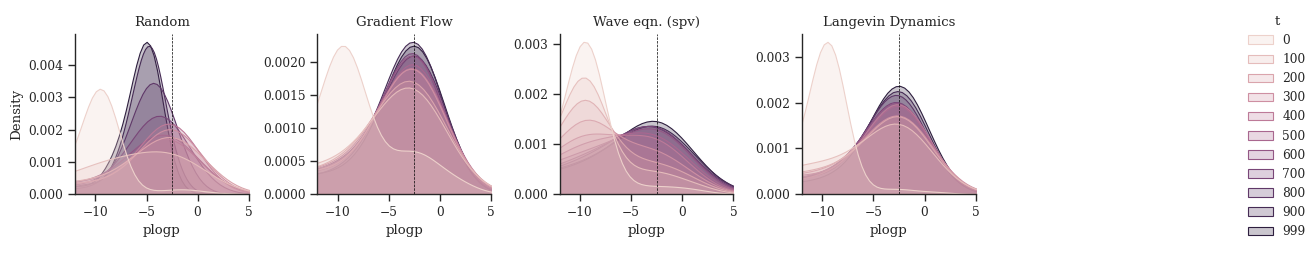

In [14]:
sns.set_theme(
    context='paper',
    style='ticks',
    palette='tab10',
    font='serif',
)

# fig, ax = plt.subplots()

sup_line = df_all.query('t == 999 and name == "Langevin Dynamics"')[prop].mean()

_df = df_all.query(
    '(t % 100 == 0 or t == 999) and name in ["Random", "Gradient Flow", "Wave eqn. (spv)", "Langevin Dynamics"]')
# _df = df_all.query('t % 100 == 0 or t == 999')

# set x-axis limits -10 to 10
g = sns.displot(_df, x=prop, hue='t', kind='kde', fill=True, col='name', height=2.5,
                col_wrap=5, facet_kws={'sharey': False})
g.set_titles('{col_name}')
g.set_xlabels('plogp')
for ax in g.axes.flat:
    ax.set_xlim(-12, 5)
    #plot vertical line at x=0
    ax.axvline(-2.5, color='black', linestyle='--', lw=0.5)
g.savefig(f'ChemFlow/figures/optimization/{prop}_spv_kde.pdf')
g.savefig(f'ChemFlow/figures/optimization/{prop}_spv_kde.png')

Table 1 results for the original methods for plogp and qed.

In [16]:
import pandas as pd
from pathlib import Path

METHOD_CONFIG = {
    "RANDOM": {"method_code": "random", "suffix": "_0.1_relative"},
    "GRADIENT FLOW": {"method_code": "limo", "suffix": "_0.1_relative"},
    "WAVE (SPV)": {"method_code": "wave_sup", "suffix": "_0.1_relative"},
    "WAVE (UNSUP)": {"method_code": "wave_unsup", "suffix": "_0.1_relative"},
    "HJ (SPV)": {"method_code": "hj_sup", "suffix": "_0.1_relative"},
    "HJ (UNSUP)": {"method_code": "hj_unsup", "suffix": "_0.1_relative"},
    "LD": {"method_code": "fp", "suffix": "_0.1_relative"},
}

PROPERTY_CONFIG = {
    "plogP ↑": {"prop_code": "plogp", "maximize": True},
    "QED ↑": {"prop_code": "qed", "maximize": True},
    "ESR1 DOCKING ↓": {"prop_code": "1err", "maximize": False},
    "ACAA1 DOCKING ↓": {"prop_code": "2iik", "maximize": False},
}

ranks = ["1ST", "2ND", "3RD"]
table_data = []
method_names_ordered = ["RANDOM", "GRADIENT FLOW", "WAVE (SPV)", "WAVE (UNSUP)", "HJ (SPV)", "HJ (UNSUP)", "LD"]
property_names_ordered = ["plogP ↑", "QED ↑"]

base_path = Path("ChemFlow/data/interim/uc_optim")

for method_display_name in method_names_ordered:
    config = METHOD_CONFIG[method_display_name]
    method_code = config["method_code"]
    suffix = config["suffix"]
    row_data = {"METHOD": method_display_name}

    for prop_display_name in property_names_ordered:
        prop_info = PROPERTY_CONFIG[prop_display_name]
        prop_code = prop_info["prop_code"]
        maximize = prop_info["maximize"]

        filename = f"{prop_code}_{method_code}{suffix}.csv"
        filepath = base_path / filename
        
        df_prop = pd.read_csv(filepath)
        
        sorted_df = df_prop.sort_values(by=prop_code, ascending=not maximize)
        top_3_values = sorted_df[prop_code].head(3).tolist()
        
        for i, rank in enumerate(ranks):
            if i < len(top_3_values):
                row_data[(prop_display_name, rank)] = top_3_values[i]
            else:
                row_data[(prop_display_name, rank)] = float('nan')
            
    table_data.append(row_data)

df_results = pd.DataFrame(table_data)
df_results = df_results.set_index("METHOD")
df_results.columns = pd.MultiIndex.from_tuples(df_results.columns)

column_formats = {}
for prop_col_name, _ in df_results.columns:
    is_docking = "DOCKING" in prop_col_name
    is_qed = prop_col_name == "QED ↑"
    
    for rank_col_name in ranks:
        if is_docking:
            column_formats[(prop_col_name, rank_col_name)] = '{:.2f}'
        elif is_qed:
            column_formats[(prop_col_name, rank_col_name)] = '{:.3f}'
        else: 
            column_formats[(prop_col_name, rank_col_name)] = '{:.2f}'
            
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
df_results

plogP ↑                         QED ↑                    
                    1ST       2ND       3RD       1ST       2ND       3RD
METHOD                                                                   
RANDOM         3.523312  3.432617  3.365955  0.940105  0.933213  0.931809
GRADIENT FLOW  4.396409  4.274495  3.779748  0.929144  0.928358  0.928266
WAVE (SPV)     4.392646  4.128367  4.051120  0.935251  0.930431  0.928137
WAVE (UNSUP)   3.541071  3.185284  3.090987  0.940782  0.935836  0.934750
HJ (SPV)       4.051120  3.779884  3.695194  0.932741  0.902463  0.894369
HJ (UNSUP)     4.527413  4.267264  3.840987  0.931676  0.928545  0.927687
LD             4.699721  4.025781  3.557703  0.944202  0.933310  0.932964

Table 3 results for the Similarity-constrained Multi-objective (QED-SA) maximization

In [17]:
import pandas as pd
from pathlib import Path
import numpy as np
from rdkit import Chem
from rdkit.Chem import DataStructs, AllChem
from tqdm import tqdm

# --- Configuration ---
METHOD_DISPLAY_TO_CODE = {
    "Random": {"code": "random", "suffix": "_0.1_absolute"},
    "Gradient Flow": {"code": "limo", "suffix": "_0.1_absolute"}, # Suffix was relative
    "Wave (SPV)": {"code": "wave_sup", "suffix": "_0.1_absolute"}, # Suffix was relative
    "Wave (UNSUP)": {"code": "wave_unsup", "suffix": "_0.1_absolute"}, # Suffix was relative
    "HJ (SPV)": {"code": "hj_sup", "suffix": "_0.1_absolute"}, # Suffix was relative
    "HJ (UNSUP)": {"code": "hj_unsup", "suffix": "_0.1_absolute"}, # Suffix was relative
    "LD": {"code": "fp", "suffix": "_0.1_absolute"}, # Suffix was relative
}
# Corrected suffixes based on user's file list for qed_sa files.

SIMILARITY_THRESHOLDS = [0.0, 0.2, 0.4, 0.6]
PROPS_TO_OPTIMIZE = ["qed", "sa"] 
N_INITIAL_MOLECULES = 800
N_OPTIMIZATION_STEPS = 1000 # Max value of 't' is steps-1

BASE_OUTPUT_PATH = Path("ChemFlow/data/interim/optimization")
ZINC250K_PROPS_PATH = Path("ChemFlow/data/interim/props/zinc250k.csv")

# --- Helper Functions ---
def get_morgan_fingerprint(mol):
    return AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)

def calculate_similarity(smiles1, smiles2):
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    if mol1 is None or mol2 is None:
        return 0.0
    fp1 = get_morgan_fingerprint(mol1)
    fp2 = get_morgan_fingerprint(mol2)
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def scale_property(value, p_min, p_max, target_min=0, target_max=100, maximize=True):
    if p_max == p_min: # Avoid division by zero
        return target_min if (maximize and value <= p_min) or (not maximize and value >= p_min) else target_max

    scaled_val = (value - p_min) / (p_max - p_min)
    if not maximize: # For minimization (like SA), invert normalized score
        scaled_val = 1 - scaled_val
    return scaled_val * (target_max - target_min) + target_min

# --- Load and Prepare Initial Data ---
df_zinc250k = pd.read_csv(ZINC250K_PROPS_PATH)
qed_min_raw, qed_max_raw = df_zinc250k["qed"].min(), df_zinc250k["qed"].max()
sa_min_raw, sa_max_raw = df_zinc250k["sa"].min(), df_zinc250k["sa"].max()

# Select initial molecules based on the logic in optimization_multi.py
df_initial_selection = df_zinc250k[["smiles", "qed", "sa"]].copy()
df_initial_selection["qed_scaled_sel"] = scale_property(df_initial_selection["qed"], qed_min_raw, qed_max_raw, target_max=50, maximize=True)
df_initial_selection["sa_scaled_sel"] = scale_property(df_initial_selection["sa"], sa_min_raw, sa_max_raw, target_max=50, maximize=False) # SA is minimized, so maximize=False gives higher score for lower SA
df_initial_selection["score_sel"] = df_initial_selection["qed_scaled_sel"] + df_initial_selection["sa_scaled_sel"]
df_initial_selection = df_initial_selection.sort_values(by="score_sel", ascending=True).head(N_INITIAL_MOLECULES)

initial_molecules_data = {}
for i, row in df_initial_selection.iterrows():
    initial_molecules_data[len(initial_molecules_data)] = { # Use simple 0-based index matching 'idx'
        "smiles": row["smiles"],
        "qed_raw": row["qed"],
        "sa_raw": row["sa"],
        "qed_scaled_100": scale_property(row["qed"], qed_min_raw, qed_max_raw, maximize=True),
        "sa_scaled_100": scale_property(row["sa"], sa_min_raw, sa_max_raw, maximize=False), # Higher scaled_100 is better
    }

# --- Main Processing Logic ---
results_qed = []
results_sa = []
methods_ordered = list(METHOD_DISPLAY_TO_CODE.keys())

for method_display_name in tqdm(methods_ordered, desc="Processing methods"):
    method_details = METHOD_DISPLAY_TO_CODE[method_display_name]
    method_code = method_details["code"]
    suffix = method_details["suffix"]

    filename = f"{PROPS_TO_OPTIMIZE[0]}_{PROPS_TO_OPTIMIZE[1]}_{method_code}{suffix}.csv"
    filepath = BASE_OUTPUT_PATH / filename

    row_data_qed = {"Method": method_display_name}
    row_data_sa = {"Method": method_display_name}

    if not filepath.exists():
        print(f"File not found: {filepath}, skipping {method_display_name}")
        for sim_thresh in SIMILARITY_THRESHOLDS:
            col_name = f"δ = {sim_thresh:.1f}"
            row_data_qed[col_name] = "N/A"
            row_data_sa[col_name] = "N/A"
        results_qed.append(row_data_qed)
        results_sa.append(row_data_sa)
        continue

    df_method_output = pd.read_csv(filepath)

    processed_steps = []
    for _, gen_row in df_method_output.iterrows():
        idx = gen_row["idx"]
        if idx not in initial_molecules_data:
            continue 
            
        initial_data = initial_molecules_data[idx]
        sim = calculate_similarity(gen_row["smiles"], initial_data["smiles"])
        
        final_qed_scaled_100 = scale_property(gen_row["qed"], qed_min_raw, qed_max_raw, maximize=True)
        final_sa_scaled_100 = scale_property(gen_row["sa"], sa_min_raw, sa_max_raw, maximize=False) # Higher is better

        delta_qed = final_qed_scaled_100 - initial_data["qed_scaled_100"]
        delta_sa = final_sa_scaled_100 - initial_data["sa_scaled_100"]
        
        processed_steps.append({
            "idx": idx, "t": gen_row["t"], "sim": sim,
            "delta_qed": delta_qed, "delta_sa": delta_sa
        })
    
    df_processed_method = pd.DataFrame(processed_steps)

    for sim_thresh in SIMILARITY_THRESHOLDS:
        col_name = f"δ = {sim_thresh:.1f}"
        df_sim_filtered = df_processed_method[df_processed_method["sim"] >= sim_thresh]

        # QED
        if not df_sim_filtered.empty:
            best_delta_qed_per_idx = df_sim_filtered.groupby("idx")["delta_qed"].max()
        else:
            best_delta_qed_per_idx = pd.Series(dtype=float)
        
        # Ensure all N_INITIAL_MOLECULES are represented, defaulting to -inf if no valid/better step found
        all_idx_best_delta_qed = pd.Series(-np.inf, index=range(N_INITIAL_MOLECULES), dtype=float)
        all_idx_best_delta_qed.update(best_delta_qed_per_idx)

        successful_qed = all_idx_best_delta_qed[all_idx_best_delta_qed > 0]
        mean_qed = successful_qed.mean() if not successful_qed.empty else 0.0
        std_qed = successful_qed.std() if not successful_qed.empty else 0.0
        succ_rate_qed = len(successful_qed) / N_INITIAL_MOLECULES if N_INITIAL_MOLECULES > 0 else 0.0
        row_data_qed[col_name] = f"{mean_qed:.1f} ± {std_qed:.1f} ({succ_rate_qed*100:.1f})"

        # SA
        if not df_sim_filtered.empty:
            best_delta_sa_per_idx = df_sim_filtered.groupby("idx")["delta_sa"].max()
        else:
            best_delta_sa_per_idx = pd.Series(dtype=float)

        all_idx_best_delta_sa = pd.Series(-np.inf, index=range(N_INITIAL_MOLECULES), dtype=float)
        all_idx_best_delta_sa.update(best_delta_sa_per_idx)

        successful_sa = all_idx_best_delta_sa[all_idx_best_delta_sa > 0]
        mean_sa = successful_sa.mean() if not successful_sa.empty else 0.0
        std_sa = successful_sa.std() if not successful_sa.empty else 0.0
        succ_rate_sa = len(successful_sa) / N_INITIAL_MOLECULES if N_INITIAL_MOLECULES > 0 else 0.0
        row_data_sa[col_name] = f"{mean_sa:.2f} ± {std_sa:.2f} ({succ_rate_sa*100:.1f})"
        
    results_qed.append(row_data_qed)
    results_sa.append(row_data_sa)



Processing methods:   0%|          | 0/7 [00:00<?, ?it/s][17:48:13] Conflicting single bond directions around double bond at index 10.
[17:48:13]   BondStereo set to STEREONONE and single bond directions set to NONE.
[17:48:13] Conflicting single bond directions around double bond at index 10.
[17:48:13]   BondStereo set to STEREONONE and single bond directions set to NONE.
[17:48:13] Conflicting single bond directions around double bond at index 10.
[17:48:13]   BondStereo set to STEREONONE and single bond directions set to NONE.
[17:48:14] Conflicting single bond directions around double bond at index 10.
[17:48:14]   BondStereo set to STEREONONE and single bond directions set to NONE.
[17:48:14] Conflicting single bond directions around double bond at index 10.
[17:48:14]   BondStereo set to STEREONONE and single bond directions set to NONE.
[17:48:14] Conflicting single bond directions around double bond at index 10.
[17:48:14]   BondStereo set to STEREONONE and single bond directi

In [18]:
# --- Display Results ---
df_table_qed = pd.DataFrame(results_qed).set_index("Method")
df_table_sa = pd.DataFrame(results_sa).set_index("Method")

# Optional: Display settings
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

# Title and display
from IPython.display import display, Markdown

display(Markdown("### Multi-objective (QED-SA) Maximization - QED Improvement"))
display(df_table_qed)

display(Markdown("### Multi-objective (QED-SA) Maximization - SA Improvement (higher scaled score is better)"))
display(df_table_sa)

### Multi-objective (QED-SA) Maximization - QED Improvement

,δ = 0.0,δ = 0.2,δ = 0.4,δ = 0.6
Method,,,,
Random,34.7 ± 16.4 (98.6),19.0 ± 14.6 (76.9),13.0 ± 11.1 (52.2),12.2 ± 12.1 (23.9)
Gradient Flow,36.4 ± 16.4 (99.4),21.7 ± 15.5 (79.1),14.9 ± 13.0 (46.1),13.6 ± 12.8 (17.6)
Wave (SPV),35.1 ± 16.7 (97.9),12.3 ± 2.6 (0.2),0.0 ± 0.0 (0.0),0.0 ± 0.0 (0.0)
Wave (UNSUP),35.2 ± 17.2 (94.5),20.7 ± 14.5 (3.9),0.0 ± 0.0 (0.0),0.0 ± 0.0 (0.0)
HJ (SPV),35.0 ± 15.7 (98.6),20.0 ± 15.3 (76.4),11.7 ± 10.8 (48.4),8.5 ± 7.6 (25.1)
HJ (UNSUP),37.6 ± 17.4 (96.5),23.7 ± 18.6 (4.4),0.0 ± 0.0 (0.0),0.0 ± 0.0 (0.0)
LD,48.8 ± 14.6 (100.0),26.1 ± 15.4 (92.8),16.4 ± 12.9 (71.6),12.7 ± 11.9 (38.8)


### Multi-objective (QED-SA) Maximization - SA Improvement (higher scaled score is better)

,δ = 0.0,δ = 0.2,δ = 0.4,δ = 0.6
Method,,,,
Random,31.11 ± 16.66 (96.0),13.27 ± 10.97 (64.0),9.26 ± 8.80 (37.6),5.37 ± 5.70 (15.8)
Gradient Flow,39.07 ± 17.99 (97.4),15.68 ± 12.54 (67.9),9.12 ± 8.40 (32.5),6.00 ± 6.82 (12.8)
Wave (SPV),32.66 ± 20.05 (95.5),7.82 ± 4.59 (0.2),0.00 ± 0.00 (0.0),0.00 ± 0.00 (0.0)
Wave (UNSUP),35.28 ± 17.09 (97.8),18.77 ± 16.98 (3.6),0.79 ± nan (0.1),0.00 ± 0.00 (0.0)
HJ (SPV),34.38 ± 18.76 (98.4),12.82 ± 11.07 (64.9),8.11 ± 8.73 (34.9),6.30 ± 7.46 (14.6)
HJ (UNSUP),38.69 ± 17.70 (97.5),22.13 ± 13.48 (5.9),24.65 ± nan (0.1),0.00 ± 0.00 (0.0)
LD,51.73 ± 18.43 (100.0),19.74 ± 13.61 (86.9),11.26 ± 9.59 (57.8),7.36 ± 7.24 (26.8)


Table 4: Success Rate of traversing latent molecule space to manipulate to manipulate a variety of properties.

In [19]:
import pandas as pd
from pathlib import Path
import numpy as np
from IPython.display import display, Markdown

METHOD_MAP = {
    "RANDOM-1D": {"file_prefix": "random_1d", "spv": False},
    "RANDOM": {"file_prefix": "random", "spv": False},
 #   "CHEMSPACE": {"file_prefix": "chemspace", "spv": False},
    "WAVE (UNSUP)": {"file_prefix": "unsup_pde", "spv": False},
    "WAVE (SPV)": {"file_prefix": "sup_pde", "spv": True},
    "HJ (UNSUP)": {"file_prefix": "unsup_hj", "spv": False},
    "HJ (SPV)": {"file_prefix": "sup_hj", "spv": True},
    "GF (SPV)": {"file_prefix": "limo", "spv": True},
    "LD (SPV)": {"file_prefix": "fp", "spv": True},
}

PROPERTIES_MAP = {
    "PLOGP (↑)": "plogp",
    "QED (↑)": "qed",
    "SA (↓)": "sa",
    "DRD2 (↑)": "drd2",
    "JNK3 (↑)": "jnk3",
    "GSK3B (↑)": "gsk3b",
}

N_MOLECULES_SUCCESS_RATE = 1000
BASE_SUCCESS_RATE_PATH = Path(f"ChemFlow/experiments/success_rate")

table_rows = []
methods_in_table_order = list(METHOD_MAP.keys())
properties_in_table_order = list(PROPERTIES_MAP.keys())

for method_display_name in methods_in_table_order:
    method_info = METHOD_MAP[method_display_name]
    file_prefix_from_map = method_info["file_prefix"]
    
    row_data = {"METHOD": method_display_name}
    all_prop_strict_rates = []
    all_prop_relaxed_rates = []

    for prop_display_name in properties_in_table_order:
        prop_code = PROPERTIES_MAP[prop_display_name]
        data_file = BASE_SUCCESS_RATE_PATH / f"{prop_code}_{N_MOLECULES_SUCCESS_RATE}.txt"
        strict_rate = 0.0
        relaxed_rate = 0.0

        if data_file.exists():
            with open(data_file, 'r') as f:
                for line in f:
                    parts = [p.strip() for p in line.split('|')]
                    if len(parts) > 1 and parts[0] == file_prefix_from_map:
                        if len(parts) >= 6: 
                            try:
                                strict_val_str = parts[4].split(' ')[-1] if ' ' in parts[4] else parts[4]
                                relaxed_val_str = parts[5].split(' ')[-1] if ' ' in parts[5] else parts[5]
                                strict_rate = float(strict_val_str) * 100
                                relaxed_rate = float(relaxed_val_str) * 100
                                break 
                            except (ValueError, IndexError):
                                pass 
                        
        row_data[prop_display_name] = f"{strict_rate:.2f} / {relaxed_rate:.2f}"
        all_prop_strict_rates.append(strict_rate)
        all_prop_relaxed_rates.append(relaxed_rate)

    avg_strict = np.mean(all_prop_strict_rates) if all_prop_strict_rates else 0.0
    avg_relaxed = np.mean(all_prop_relaxed_rates) if all_prop_relaxed_rates else 0.0
    row_data["AVERAGE_STRICT_VAL"] = avg_strict
    row_data["AVERAGE_RELAXED_VAL"] = avg_relaxed
    row_data["AVERAGE_DISPLAY"] = f"{avg_strict:.2f} / {avg_relaxed:.2f}"
    table_rows.append(row_data)

df_results = pd.DataFrame(table_rows)
df_results = df_results.set_index("METHOD") 

df_results['RANK_STRICT'] = df_results['AVERAGE_STRICT_VAL'].rank(method='min', ascending=False)
df_results['RANK_RELAXED'] = df_results['AVERAGE_RELAXED_VAL'].rank(method='min', ascending=False)
df_results['AVERAGE_OF_RANKS'] = (df_results['RANK_STRICT'] + df_results['RANK_RELAXED']) / 2
df_results['RANKING'] = df_results['AVERAGE_OF_RANKS'].rank(method='min').astype(int)

cols_display = ['RANKING', 'AVERAGE_DISPLAY'] + properties_in_table_order
df_final_display = df_results.reindex(methods_in_table_order)[cols_display]
df_final_display.rename(columns={'AVERAGE_DISPLAY': 'AVERAGE'}, inplace=True)
df_final_display.index.name = None

styled_table = df_final_display.style.set_caption("Table 4: Success Rate of Traversing Latent Molecule Space").set_table_styles(
    [{'selector': 'caption',
      'props': [('color', 'black'),
                ('font-size', '16px'),
                ('font-weight', 'bold'),
                ('text-align', 'center')]}
    ]
).format(precision=2)

display(Markdown("### Table 4: Success Rate of Traversing Latent Molecule Space"))
display(styled_table)

### Table 4: Success Rate of Traversing Latent Molecule Space

,RANKING,AVERAGE,PLOGP (↑),QED (↑),SA (↓),DRD2 (↑),JNK3 (↑),GSK3B (↑)
RANDOM-1D,8,0.00 / 0.00,0.00 / 0.00,0.00 / 0.00,0.00 / 0.00,0.00 / 0.00,0.00 / 0.00,0.00 / 0.00
RANDOM,5,0.63 / 43.72,0.60 / 34.90,1.00 / 12.10,0.30 / 7.10,0.60 / 88.90,0.80 / 81.50,0.50 / 37.80
WAVE (UNSUP),2,5.03 / 52.75,3.60 / 51.40,5.70 / 31.10,2.70 / 11.50,5.10 / 87.50,7.10 / 81.70,6.00 / 53.30
WAVE (SPV),6,4.80 / 22.87,3.40 / 16.80,6.90 / 24.30,6.30 / 28.20,9.60 / 60.50,1.80 / 3.60,0.80 / 3.80
HJ (UNSUP),7,1.42 / 20.03,1.60 / 41.20,3.10 / 22.00,0.90 / 6.90,0.00 / 0.00,0.00 / 0.00,2.90 / 50.10
HJ (SPV),3,5.20 / 27.87,4.60 / 28.50,8.20 / 35.40,3.50 / 11.70,9.50 / 71.10,1.10 / 2.20,4.30 / 18.30
GF (SPV),1,6.98 / 28.02,6.50 / 30.40,4.90 / 18.60,8.20 / 23.70,5.70 / 31.90,10.00 / 35.20,6.60 / 28.30
LD (SPV),3,5.90 / 26.28,4.90 / 29.10,4.80 / 17.50,5.90 / 21.20,4.90 / 29.60,8.50 / 34.00,6.40 / 26.30


Up to here we have dealt with the inital implementation. Moving now to extensions.

Perform the random walkd and the neyghboring search for unsuperivsed scenario using MolGenTransformers for qed.

In [ ]:
!python ChemFlow/extend/MolgenRandomWalkSimilarityConstrained.py qed

Same for plogp

In [ ]:
!python ChemFlow/extend/MolgenRandomWalkSimilarityConstrained.py plogp

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

def get_top_n_property_values(df_for_selection: pd.DataFrame, property_col: str, n_top: int, ascending_order: bool):
    if df_for_selection.empty or property_col not in df_for_selection.columns:
        return [np.nan] * n_top
    
    sorted_df = df_for_selection.sort_values(by=property_col, ascending=ascending_order, na_position='last')
    top_values = sorted_df[property_col].head(n_top).tolist()
    
    if len(top_values) < n_top:
        top_values.extend([np.nan] * (n_top - len(top_values)))
    return top_values

def analyze_method_results(
    plogp_csv_path_str: str,
    qed_csv_path_str: str,
    blacklist_smiles: set
):
    plogp_path = Path(plogp_csv_path_str)
    qed_path   = Path(qed_csv_path_str)
    
    default_results = {
        ('plogP ↑', '1ST'): np.nan, ('plogP ↑', '2ND'): np.nan, ('plogP ↑', '3RD'): np.nan,
        ('QED ↑',  '1ST'): np.nan, ('QED ↑',  '2ND'): np.nan, ('QED ↑',  '3RD'): np.nan,
    }

    if not plogp_path.is_file() or not qed_path.is_file():
        return default_results

    df_plogp = pd.read_csv(plogp_path).dropna(subset=['smiles','plogp'])
    df_qed   = pd.read_csv(qed_path)  .dropna(subset=['smiles','qed'])
    df_plogp['smiles'] = df_plogp['smiles'].astype(str)
    df_qed['smiles']   = df_qed['smiles'].astype(str)

    df_plogp = df_plogp[~df_plogp['smiles'].isin(blacklist_smiles)].drop_duplicates('smiles', keep='first')
    df_qed   = df_qed[~df_qed['smiles'].isin(blacklist_smiles)].drop_duplicates('smiles', keep='first')
    if df_plogp.empty or df_qed.empty:
        return default_results

    top_plogp = get_top_n_property_values(df_plogp, 'plogp', 3, False)
    top_qed   = get_top_n_property_values(df_qed,   'qed',   3, False)
    
    return {
        ('plogP ↑', '1ST'): top_plogp[0], ('plogP ↑', '2ND'): top_plogp[1], ('plogP ↑', '3RD'): top_plogp[2],
        ('QED ↑',  '1ST'): top_qed[0],  ('QED ↑',  '2ND'): top_qed[1],  ('QED ↑',  '3RD'): top_qed[2],
    }

blacklist_file_path = "ChemFlow/data/interim/props/zinc250k.csv"

input_csv_for_random_walk = "ChemFlow/extend/optimization_results_molgen_truncated_100steps/plogp_random_walk_s2.0_t100_n800.csv"
input_csv_for_neighbor_search = "ChemFlow/extend/optimization_results_molgen_truncated_100steps/plogp_neighboring_search_nv10_r20.0_res0.05_n800.csv"

loaded_blacklist_smiles = set()
blacklist_path_obj = Path(blacklist_file_path)
if blacklist_path_obj.is_file():
    df_blacklist_data = pd.read_csv(blacklist_path_obj)
    if 'smiles' in df_blacklist_data.columns:
        loaded_blacklist_smiles = set(df_blacklist_data['smiles'].astype(str).dropna())

analysis_rows = []

method_configurations = [
    {
      "name": "random_walk_transformer",
      "plogp_path": input_csv_for_random_walk,
      "qed_path":   input_csv_for_random_walk.replace("plogp", "qed")
    },
    {
      "name": "neighbor_search_transformer",
      "plogp_path": input_csv_for_neighbor_search,
      "qed_path":   input_csv_for_neighbor_search.replace("plogp", "qed")
    }
]

for config in method_configurations:
    current_method_properties = analyze_method_results(
        config["plogp_path"],
        config["qed_path"],
        loaded_blacklist_smiles
    )
    current_method_row = {'METHOD': config["name"], **current_method_properties}
    analysis_rows.append(current_method_row)

output_dataframe = pd.DataFrame(analysis_rows)

if not output_dataframe.empty:
    output_dataframe = output_dataframe.set_index('METHOD')
    
    column_multi_index = pd.MultiIndex.from_tuples([
        ('plogP ↑', '1ST'), ('plogP ↑', '2ND'), ('plogP ↑', '3RD'),
        ('QED ↑',  '1ST'), ('QED ↑',  '2ND'), ('QED ↑',  '3RD')
    ])
    output_dataframe = output_dataframe.reindex(columns=column_multi_index)
else:
    column_multi_index = pd.MultiIndex.from_product(
        [['plogP ↑', 'QED ↑'], ['1ST', '2ND', '3RD']],
    )
    output_dataframe = pd.DataFrame(columns=column_multi_index, index=pd.Index([], name='METHOD'))
    
output_dataframe


plogP ↑                         QED ↑                    
                                  1ST       2ND       3RD       1ST       2ND       3RD
METHOD                                                                                 
random_walk_transformer      4.519903  4.397062  4.377148  0.948442  0.948331  0.948258
neighbor_search_transformer  5.345118  5.323837  5.140254  0.948442  0.948442  0.948434

These are some approaches to train a neural ode that did not work.

In [ ]:
!python experiments/train_neural_ode.py --prop_name plogp --data_name zmc --is_supervised --epochs 40 --output_dir_base checkpoints/neural_ode --model_params.latent_dim 1024 --model_params.learning_rate 1e-4 --model_params.integration_time_step 0.2 --model_params.num_loss_integration_steps 5 --model_params.flow_reg_lambda 0.01 --data_params.batch_size 128

/home/akouk/miniconda3/envs/chemflow_gpu/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Traceback (most recent call last):
  File "/data/hdd1/users/akouk/moldecular_biology_dsit/ChemFlow/experiments/train_neural_ode.py", line 15, in <module>
    from src.vae import load_vae, VAE
  File "/data/hdd1/users/akouk/moldecular_biology_dsit/ChemFlow/src/vae/__init__.py", line 3, in <module>
    from .utils import load_vae, load_vae_demo
  File "/data/hdd1/users/akouk/moldecular_biology_dsit/ChemFlow/src/vae/utils.py", line 3, in <module>
    from ChemFlow.src.vae import VAE, MolDataModule
ModuleNotFoundError: No module named 'ChemFlow'


In [ ]:
!python experiments/train_neural_ode.py     --prop_name qed     --data_name zmc     --is_supervised     --epochs 40     --output_dir_base checkpoints/neural_ode     --model_params.latent_dim 1024     --model_params.learning_rate 1e-4     --model_params.integration_time_step 0.2     --model_params.num_loss_integration_st eps 5     --model_params.flow_reg_lambda 0.01     --data_params.batch_size 128

In [ ]:
!python experiments/optimization/uc_optim.py     --prop plogp     --method neural_ode     --data_name zmc     --n 100000     --steps 10     --batch_size 1000     --step_size 0.1     --seed 42

In [ ]:
!python experiments/optimization/uc_optim.py     --prop qed     --method neural_ode     --data_name zmc     --n 100000     --steps 10     --batch_size 1000     --step_size 0.1     --seed 42

Present the results for qed and plogp

In [22]:
import pandas as pd
from pathlib import Path
import numpy as np

METHOD_CONFIG = {
    "RANDOM": {"method_code": "random", "suffix": "_0.1_relative"},
    "GRADIENT FLOW": {"method_code": "limo", "suffix": "_0.1_relative"},
    "WAVE (SPV)": {"method_code": "wave_sup", "suffix": "_0.1_relative"},
    "WAVE (UNSUP)": {"method_code": "wave_unsup", "suffix": "_0.1_relative"},
    "HJ (SPV)": {"method_code": "hj_sup", "suffix": "_0.1_relative"},
    "HJ (UNSUP)": {"method_code": "hj_unsup", "suffix": "_0.1_relative"},
    "LD": {"method_code": "fp", "suffix": "_0.1_relative"},
    "ODE": {"method_code": "neural_ode", "suffix": "_0.1_relative"},
    "LATENT STEPPER": {"method_code": "latent_stepper", "suffix": "_0.1_relative"},
    "hybrid_ld_hj": {"method_code": "hybrid_sup_unsup", "suffix": "_0.1_relative"},
}

PROPERTY_CONFIG = {
    "plogP ↑": {"prop_code": "plogp", "maximize": True},
    "QED ↑": {"prop_code": "qed", "maximize": True},
    "ESR1 DOCKING ↓": {"prop_code": "1err", "maximize": False},
    "ACAA1 DOCKING ↓": {"prop_code": "2iik", "maximize": False},
}

ranks = ["1ST", "2ND", "3RD"]
table_data = []
method_names_ordered = [
    "RANDOM", "GRADIENT FLOW", "WAVE (SPV)", "WAVE (UNSUP)",
    "HJ (SPV)", "HJ (UNSUP)", "LD", "ODE",
    "LATENT STEPPER", "hybrid_ld_hj"
]
property_names_ordered = ["plogP ↑", "QED ↑"]

base_path = Path("ChemFlow/data/interim/uc_optim")

for method_display_name in method_names_ordered:
    config = METHOD_CONFIG[method_display_name]
    method_code = config["method_code"]
    suffix = config["suffix"]
    row_data = {"METHOD": method_display_name}

    for prop_display_name in property_names_ordered:
        prop_info = PROPERTY_CONFIG[prop_display_name]
        prop_code = prop_info["prop_code"]
        maximize = prop_info["maximize"]

        filename = f"{prop_code}_{method_code}{suffix}.csv"
        filepath = base_path / filename

        # try to read the file, otherwise fill with NaNs
        try:
            df_prop = pd.read_csv(filepath)
            sorted_df = df_prop.sort_values(by=prop_code, ascending=not maximize)
            top_3_values = sorted_df[prop_code].head(3).tolist()
        except FileNotFoundError:
            top_3_values = [np.nan, np.nan, np.nan]

        for i, rank in enumerate(ranks):
            row_data[(prop_display_name, rank)] = top_3_values[i]

    table_data.append(row_data)
    # Add analysis_rows results to table_data
for method_name, row in output_dataframe.iterrows():
    method_row = {"METHOD": method_name}
    
    # Add all property-rank pairs from the row to method_row
    for (prop_name, rank), value in row.items():
        method_row[(prop_name, rank)] = value
    
    table_data.append(method_row)
df_results = pd.DataFrame(table_data)
#concate output_dataframe and table_data to df_results
#df1_for_concat = output_dataframe.reset_index()
#df2_for_concat = pd.DataFrame(table_data)
#df_results = pd.concat([df1_for_concat, df2_for_concat], axis=0, ignore_index=True)
df_results = df_results.set_index("METHOD")
df_results.columns = pd.MultiIndex.from_tuples(df_results.columns)

# formatting strings per column
column_formats = {}
for prop_col_name, _ in df_results.columns:
    is_docking = "DOCKING" in prop_col_name
    is_qed = prop_col_name == "QED ↑"
    for rank_col_name in ranks:
        if is_docking:
            column_formats[(prop_col_name, rank_col_name)] = "{:.2f}"
        elif is_qed:
            column_formats[(prop_col_name, rank_col_name)] = "{:.3f}"
        else:
            column_formats[(prop_col_name, rank_col_name)] = "{:.2f}"

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

# --- NEW: use Styler to format and bold the best values ---
styler = (
    df_results
    .style
    .format(column_formats)
    .highlight_max(axis=0, props="font-weight:bold")
)

styler

its time to measure the 'real' properties of our molecules

In [1]:
import pandas as pd
import os
from rdkit import Chem

# --- The Normalization Function ---
# This function takes a SMILES string, tries to read it,
# removes explicit hydrogens, and returns a clean, canonical SMILES string.
# If it fails at any point, it returns None.
def normalize_and_validate_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        Chem.RemoveHs(mol)
        return Chem.MolToSmiles(mol, isomericSmiles=True)
    except:
        return None

# --- Main Data Loading and Processing Loop ---
file_paths = [
    "ChemFlow/data/interim/uc_optim/plogp_random_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_random_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_limo_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_limo_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_wave_sup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_wave_sup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_wave_unsup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_wave_unsup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_hj_sup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_hj_sup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_hj_unsup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_hj_unsup_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_fp_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_fp_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_neural_ode_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/qed_neural_ode_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_latent_stepper_0.1_relative.csv",
    "ChemFlow/data/interim/uc_optim/plogp_hybrid_sup_unsup_0.1_relative.csv",
    "ChemFlow/extend/optimization_results_molgen_truncated_100steps/plogp_random_walk_s2.0_t100_n800.csv",
    "ChemFlow/extend/optimization_results_molgen_truncated_100steps/qed_random_walk_s2.0_t100_n800.csv",
    "ChemFlow/extend/optimization_results_molgen_truncated_100steps/plogp_neighboring_search_nv10_r20.0_res0.05_n800.csv",
    "ChemFlow/extend/optimization_results_molgen_truncated_100steps/qed_neighboring_search_nv10_r20.0_res0.05_n800.csv"
]

top_molecules_list = []
for file_path in file_paths:
    df = pd.read_csv(file_path)
    df['smiles'] = df['smiles'].str.strip()
    filename = os.path.basename(file_path)
    if 'qed' in filename: score_column = 'qed'
    else: score_column = 'plogp'
    optimization_method = filename.replace('.csv', '').replace('_0.1_relative', '')
    top_3_df = df.sort_values(by=score_column, ascending=False).head(3).copy()
    top_3_df['optimization_method'] = optimization_method
    top_3_df['score_type'] = score_column
    top_3_df['original_score'] = top_3_df[score_column]
    top_molecules_list.append(top_3_df)

master_df = pd.concat(top_molecules_list, ignore_index=True)

# --- Apply the new normalization and validation step ---
master_df['clean_smiles'] = master_df['smiles'].apply(normalize_and_validate_smiles)

# Create the final, clean DataFrame by dropping any rows where normalization failed
valid_master_df = master_df.dropna(subset=['clean_smiles']).copy()

# Create the RDKit molecule objects from the CLEANED smiles
valid_master_df['rdkit_mol'] = valid_master_df['clean_smiles'].apply(Chem.MolFromSmiles)

print(f"Total molecules loaded: {len(master_df)}")
print(f"Total VALID and NORMALIZED molecules: {len(valid_master_df)}")

Total molecules loaded: 66
Total VALID and NORMALIZED molecules: 66


Visualize the molecules

--- Generating Final Grid Image in Chunks of 12 ---


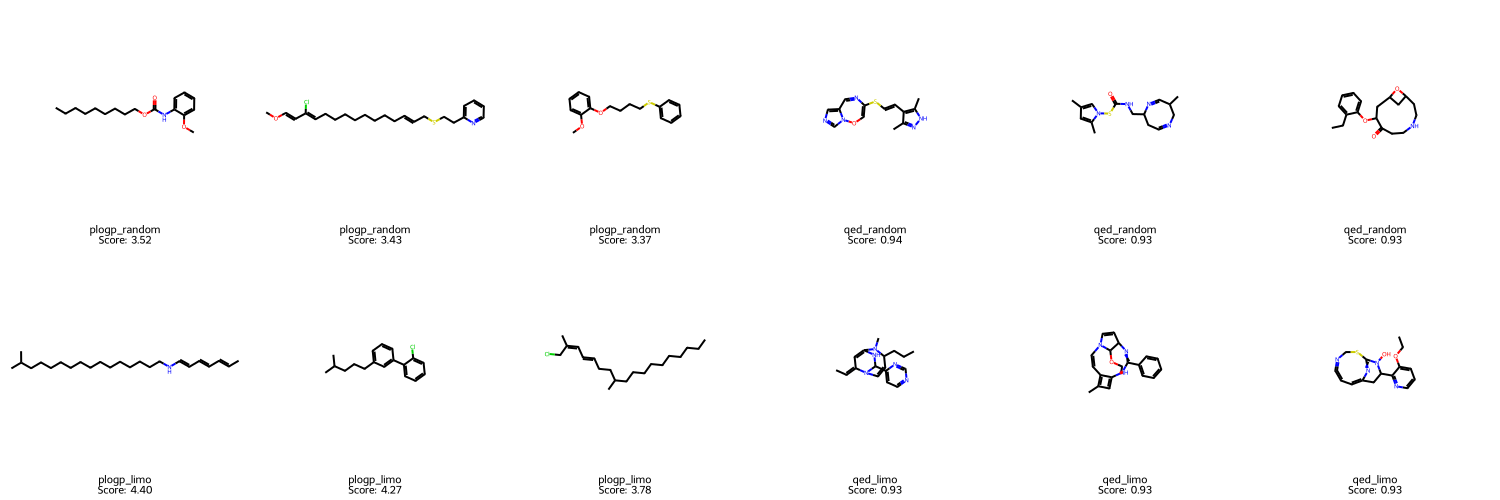

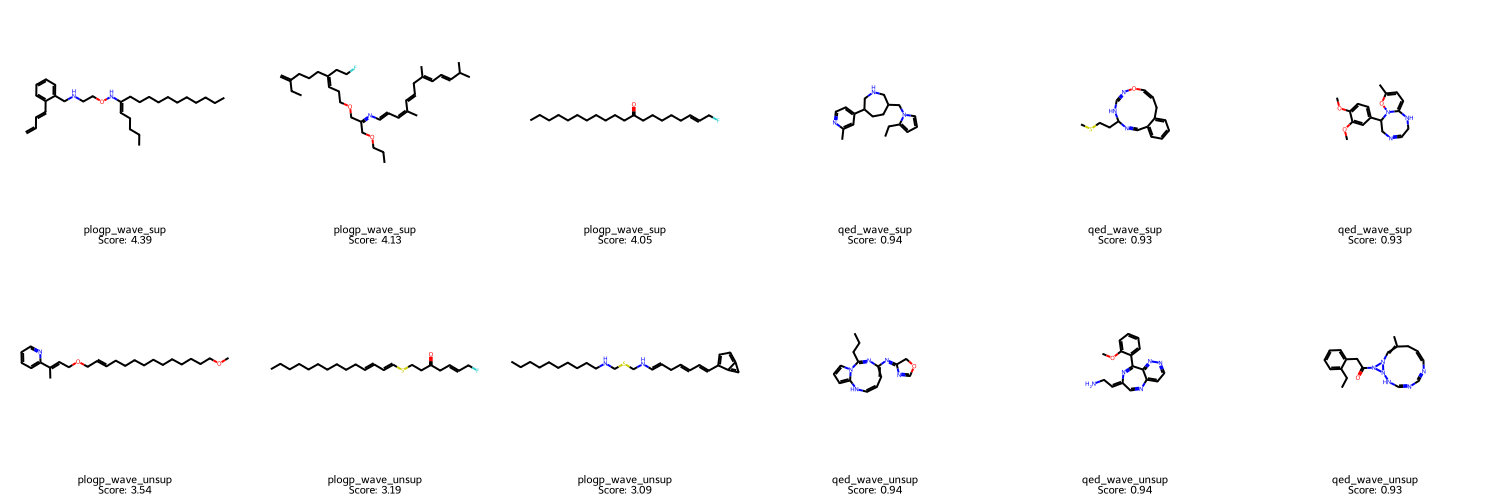

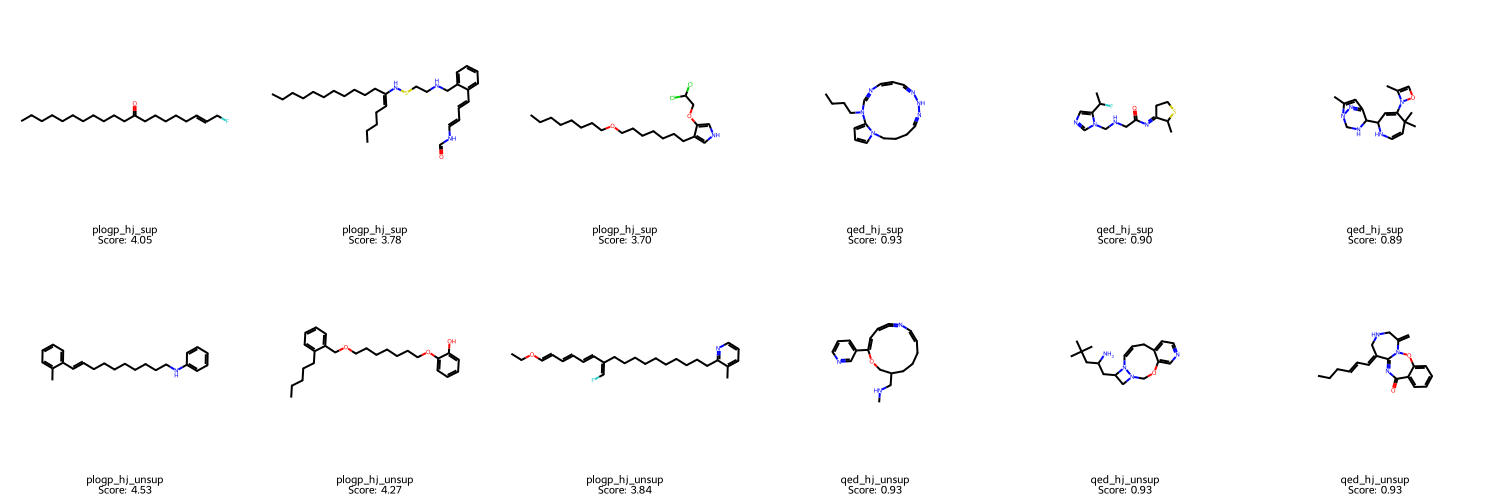

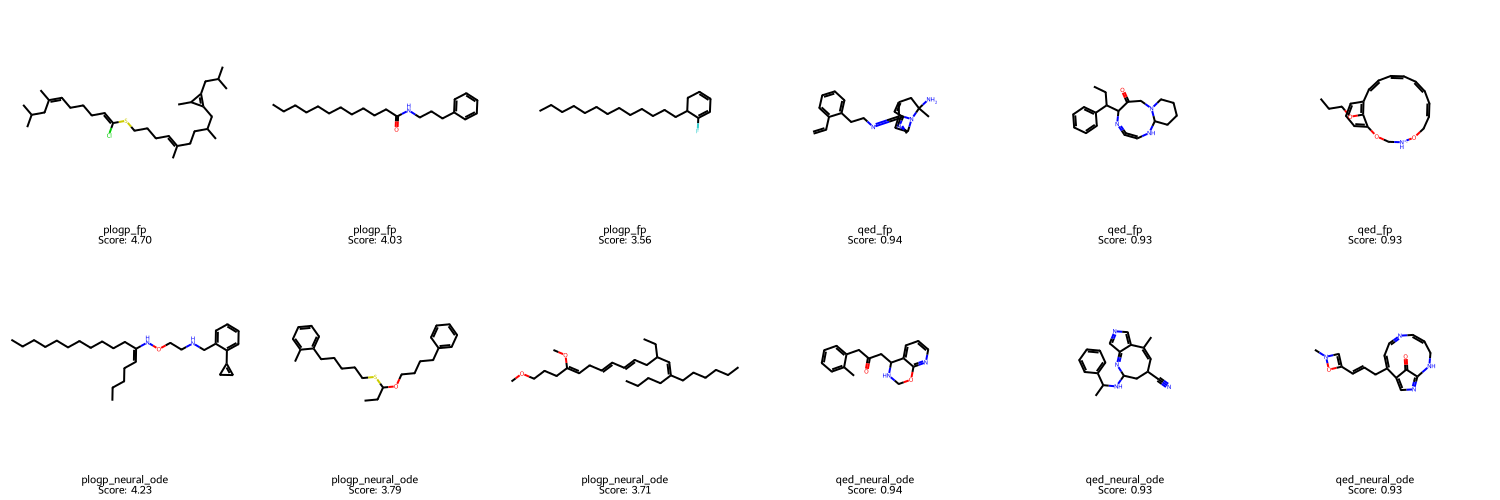

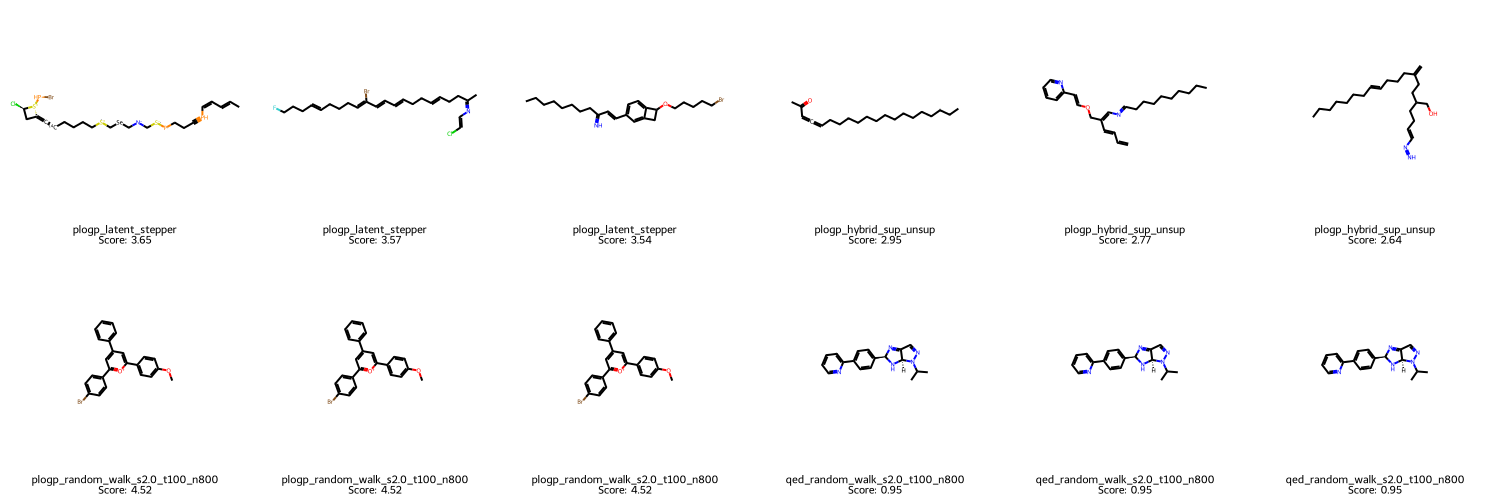

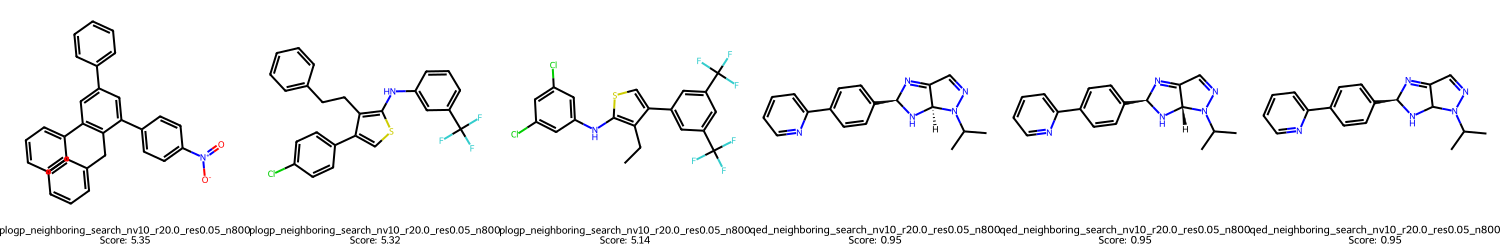


--- Full Grid Generation Complete ---


In [2]:
from rdkit.Chem import Draw
from IPython.display import display

# --- Final Grid Generation in Chunks ---

# Use the fully validated and normalized data
mols = list(valid_master_df['rdkit_mol'])
legends = [f"{row['optimization_method']}\nScore: {row['original_score']:.2f}" for index, row in valid_master_df.iterrows()]

# The chunk size can be adjusted for layout preference. 12 is a good number for a wide display.
chunk_size = 12
print(f"--- Generating Final Grid Image in Chunks of {chunk_size} ---")

for i in range(0, len(mols), chunk_size):
    start_index = i
    end_index = i + chunk_size
    
    mol_chunk = mols[start_index:end_index]
    legend_chunk = legends[start_index:end_index]
    
    try:
        # Generate the image for the current chunk
        img = Draw.MolsToGridImage(mol_chunk, molsPerRow=6, subImgSize=(250, 250), legends=legend_chunk)
        
        # Display the image for this chunk
        display(img)
        
    except Exception as e:
        # This part should not be triggered now, but it's good practice to keep it
        print(f"\n--- SKIPPING a problematic chunk (indices {start_index}-{end_index-1}) due to an error ---")
        print(f"Error: {e}")
        continue

print("\n--- Full Grid Generation Complete ---")

In [3]:
from rdkit.Chem import Descriptors

mol_objects = [Chem.MolFromSmiles(s) for s in master_df['smiles']]

master_df['MolWt'] = [Descriptors.MolWt(m) for m in mol_objects]
master_df['LogP'] = [Descriptors.MolLogP(m) for m in mol_objects]
master_df['NumHDonors'] = [Descriptors.NumHDonors(m) for m in mol_objects]
master_df['NumHAcceptors'] = [Descriptors.NumHAcceptors(m) for m in mol_objects]
master_df['NumRotatableBonds'] = [Descriptors.NumRotatableBonds(m) for m in mol_objects]
# set display to display all rows 
pd.set_option('display.max_rows', None)
display(master_df[['optimization_method', 'original_score', 'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors']].round(2))

,optimization_method,original_score,MolWt,LogP,NumHDonors,NumHAcceptors
0,plogp_random,3.52,293.41,4.99,1,3
1,plogp_random,3.43,408.05,7.32,0,3
2,plogp_random,3.37,288.41,4.65,0,3
3,qed_random,0.94,287.35,2.29,1,6
4,qed_random,0.93,306.44,2.86,1,5
5,qed_random,0.93,303.40,2.50,1,4
6,plogp_limo,4.40,347.63,7.95,1,1
7,plogp_limo,4.27,272.82,5.99,0,0
8,plogp_limo,3.78,312.97,7.67,0,0
9,qed_limo,0.93,297.41,2.75,1,5


In [4]:
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

def count_lipinski_violations(mol):
    violations = 0
    if Descriptors.MolWt(mol) > 500:
        violations += 1
    if Descriptors.MolLogP(mol) > 5:
        violations += 1
    if Descriptors.NumHDonors(mol) > 5:
        violations += 1
    if Descriptors.NumHAcceptors(mol) > 10:
        violations += 1
    return violations

def has_pains(mol):
    return catalog.HasMatch(mol)

master_df['Lipinski_Violations'] = [count_lipinski_violations(m) for m in mol_objects]
master_df['Is_PAINS'] = [has_pains(m) for m in mol_objects]
master_df['TPSA'] = [Descriptors.TPSA(m) for m in mol_objects]

pd.set_option('display.max_rows', len(master_df))
display(master_df[['optimization_method', 'original_score', 'Lipinski_Violations', 'Is_PAINS', 'TPSA']].round(2))

,optimization_method,original_score,Lipinski_Violations,Is_PAINS,TPSA
0,plogp_random,3.52,0,False,47.56
1,plogp_random,3.43,1,False,22.12
2,plogp_random,3.37,0,False,18.46
3,qed_random,0.94,0,False,68.09
4,qed_random,0.93,0,False,58.75
5,qed_random,0.93,0,False,47.56
6,plogp_limo,4.40,1,False,12.03
7,plogp_limo,4.27,1,False,0.00
8,plogp_limo,3.78,1,False,0.00
9,qed_limo,0.93,0,False,44.29


Donwload the targets

3D Ligan filed for docking preperation of the molecules

In [4]:
master_df = pd.read_csv("master_df.csv")

In [5]:
ligand_dir = "ligand_files_3d"
os.makedirs(ligand_dir, exist_ok=True)

for index, row in master_df.iterrows():
    mol = Chem.MolFromSmiles(row['smiles'])
    mol_h = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol_h, randomSeed=42)
    try:
        AllChem.MMFFOptimizeMolecule(mol_h)
    except:
        continue
    ligand_filename = os.path.join(ligand_dir, f"ligand_{index}.sdf")
    writer = Chem.SDWriter(ligand_filename)
    writer.write(mol_h)
    writer.close()

print(f"Generated 3D structures for all {len(master_df)} ligands in '{ligand_dir}'")

[17:51:11] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[17:51:11] UFFTYPER: Unrecognized charge state for atom: 9
[17:51:11] UFFTYPER: Unrecognized charge state for atom: 27


Generated 3D structures for all 66 ligands in 'ligand_files_3d'


In [6]:
import py3Dmol
import os
import re

# Define the optimization methods from the last 4 files
last_four_methods = [
    "plogp_random_walk_s2.0_t100_n800",
    "qed_random_walk_s2.0_t100_n800",
    "plogp_neighboring_search_nv10_r20.0_res0.05_n800",
    "qed_neighboring_search_nv10_r20.0_res0.05_n800"
]

# Filter the master DataFrame to get only the molecules from these methods
subset_df = master_df[master_df['optimization_method'].isin(last_four_methods)].reset_index()

# Setup the grid for 12 molecules (3 rows, 4 columns)
rows = 3
cols = 4
view = py3Dmol.view(width=1200, height=600, viewergrid=(rows, cols))

for i, row_data in subset_df.iterrows():
    # The original index is what we used to name the file
    original_index = row_data['index']
    sdf_file = os.path.join(ligand_dir, f"ligand_{original_index}.sdf")
    
    with open(sdf_file, 'r') as f:
        sdf_content = f.read()
    
    # Get metadata for the label
    opt_method = row_data['optimization_method']
    score = row_data['original_score']
    label = f"L{original_index}: {opt_method[:20]}... ({score:.2f})"
    
    viewer_row = i // cols
    viewer_col = i % cols
    
    view.addModel(sdf_content, 'sdf', viewer=(viewer_row, viewer_col))
    view.setStyle({'stick': {}}, viewer=(viewer_row, viewer_col))
    #view.addLabel(label, {'fontColor':'black', 'backgroundColor': 'lightgray', 'fontSize': 12}, viewer=(viewer_row, viewer_col))
    view.zoomTo(viewer=(viewer_row, viewer_col))

view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
from typing import Callable
# import wget

import random
import numpy as np
import matplotlib.pyplot as plt

import torch

from ChemFlow.src.vae import load_vae_demo,load_vae
from ChemFlow.src.pinn.pde import load_wavepde
from ChemFlow.src.pinn import PropGenerator, VAEGenerator
from ChemFlow.src.predictor import Predictor

from rdkit import Chem
from rdkit.Chem import Draw
from tdc import Oracle

SmilesScorer = Callable[[str | list[str]], float | list[float]]

smiles2sa: SmilesScorer = Oracle(name="SA")
smiles2qed: SmilesScorer = Oracle(name="QED")
smiles2plogp: SmilesScorer = Oracle(name="LogP")  
smiles2gsk3b: SmilesScorer = Oracle(name="GSK3B")
smiles2jnk3: SmilesScorer = Oracle(name="JNK3")
smiles2drd2: SmilesScorer = Oracle(name="DRD2")

PROP_FN = {
    "sa": smiles2sa,
    "qed": smiles2qed,
    "plogp": smiles2plogp,
    "gsk3b": smiles2gsk3b,
    "jnk3": smiles2jnk3,
    "drd2": smiles2drd2,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type != "cuda":
    raise ValueError("This notebook requires a GPU")

def normalize(x, step_size=None, relative=False):
    if step_size is None:
        return x
    if relative:
        return x * step_size
    try:
        return x / torch.norm(x, dim=-1, keepdim=True) * step_size
    except AttributeError:
        return x




def get_model(model_name, prop_name, dm, vae):
    """Gets model by name."""

    if model_name == 'Random-1D':
        rand_1d_u_z = torch.zeros(1024).to(device)
        rand_1d_u_z[torch.randint(0, 1024, (1,))] = random.choice([-1, 1])
        return rand_1d_u_z, None
    elif model_name == 'Random':
        rand_u_z = torch.randn(1024, device=device)
        return rand_u_z, None


    predictor = Predictor(dm.max_len * dm.vocab_size)

    prop_name = prop_name.lower()
    predictor.load_state_dict(
        torch.load(
            f"ChemFlow/checkpoints/prop_predictor/{prop_name}/checkpoint.pt", map_location=device
        )
    )

    # print('loaded predictor')
    for p in predictor.parameters():
        p.requires_grad = False

    sup_generator = PropGenerator(vae, predictor).to(device)
    for p in sup_generator.parameters():
        p.requires_grad = False

    unsup_generator = VAEGenerator(vae).to(device)

    unsup_pde = load_wavepde(
        checkpoint=f"ChemFlow/checkpoints/wavepde/zmc/checkpoint.pt",
        generator=unsup_generator,
        k=10,
        device=device,
    )


    # print('loaded unsup pde')
    wave_idx_map = {"plogp": 0, "sa": 6, "qed": 4, "drd2": 2, "jnk3": 0, "gsk3b": 0}
    unsup_pde_idx = wave_idx_map[prop_name]
    for p in unsup_pde.parameters():
        p.requires_grad = False

    sup_pde = load_wavepde(
        checkpoint=f"ChemFlow/checkpoints/wavepde_prop/zmc/{prop_name}/checkpoint.pt",
        generator=sup_generator,
        k=1,
        device=device,
    )


    # print('loaded sup pde')
    sup_pde_idx = 0
    for p in sup_pde.parameters():
        p.requires_grad = False

    if model_name == 'Wave (unsupervised)':
        return unsup_pde, unsup_pde_idx
    elif model_name == 'Wave (supervised)':
        return sup_pde, sup_pde_idx
    elif model_name == 'Gradient Flow' or model_name == 'Langevin Dynamics':
        return sup_pde, None,

    unsup_hj = load_wavepde(
        checkpoint=f"ChemFlow/checkpoints/hjpde/zmc/checkpoint.pt",
        generator=unsup_generator,
        k=10,
        device=device,
    )
    # print('loaded unsup hj')
    hj_idx_map = {"plogp": 5, "sa": 1, "qed": 9, "drd2": 6, "jnk3": 5, "gsk3b": 5}
    unsup_hj_idx = hj_idx_map[prop_name]
    for p in unsup_hj.parameters():
        p.requires_grad = False

    sup_hj = load_wavepde(
        checkpoint=f"ChemFlow/checkpoints/hjpde_prop/zmc/{prop_name}/checkpoint.pt",
        generator=sup_generator,
        k=1,
        device=device,
    )

    # print('loaded sup hj')
    sup_hj_idx = 0
    for p in sup_hj.parameters():
        p.requires_grad = False


    if model_name == 'HJ (unsupervised)':
        return unsup_hj, unsup_hj_idx
    elif model_name == 'HJ (supervised)':
        return sup_hj, sup_hj_idx
    else:
        raise ValueError(f"Invalid model name: {model_name}")



def sample(num_samples=1):
    """Samples latent codes."""
    z0 = torch.randn((num_samples, 1024), device=device)
    return z0


def synthesize_original(_code, _vae, _dm, _device):
    z = _code.clone()
    z = torch.from_numpy(z.detach().cpu().numpy()).float().to(_device)
    x = _vae.decode(z).exp()
    smiles = _dm.decode(x)[0]
    plogp_val = PROP_FN['plogp'](smiles)
    sa_val = PROP_FN['sa'](smiles)
    qed_val = PROP_FN['qed'](smiles)
    drd2_val = PROP_FN['drd2'](smiles)
    jnk3_val = PROP_FN['jnk3'](smiles)
    gsk3b_val = PROP_FN['gsk3b'](smiles)
    label = f'{smiles} \n plogp⬆ {plogp_val:.3f} \n sa⬇ {sa_val:.3f} \n qed⬆ {qed_val:.3f} \n drd2⬆ {drd2_val:.3f} \n jnk3⬆ {jnk3_val:.3f} \n gsk3b⬆ {gsk3b_val:.3f}'
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, legends=label)
    return img, label


def synthesize_final(_code, _vae, _dm, _device):
    z = torch.from_numpy(_code.detach().cpu().numpy()).float().to(_device)
    x = _vae.decode(z).exp()
    smiles = _dm.decode(x)[0]
    plogp_val = PROP_FN['plogp'](smiles)
    sa_val = PROP_FN['sa'](smiles)
    qed_val = PROP_FN['qed'](smiles)
    drd2_val = PROP_FN['drd2'](smiles)
    jnk3_val = PROP_FN['jnk3'](smiles)
    gsk3b_val = PROP_FN['gsk3b'](smiles)
    label = f'{smiles} \n plogp⬆ {plogp_val:.3f} \n sa⬇ {sa_val:.3f} \n qed⬆ {qed_val:.3f} \n drd2⬆ {drd2_val:.3f} \n jnk3⬆ {jnk3_val:.3f} \n gsk3b⬆ {gsk3b_val:.3f}'
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol, legends=label)
    return img, label

properties = ["plogp", "sa", "qed", "drd2", "jnk3", "gsk3b"]

dm, vae = load_vae(device=device)

/home/akouk/miniconda3/envs/chemflow_gpu/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Found local copy...
Found local copy...
Found local copy...


Failed to load tokenized dataset from ChemFlow/data/processed/zmc_data.pt: No module named 'src.vae'
Tokenizing dataset and saving to ChemFlow/data/processed/zmc_data.pt
INFO: Pandarallel will run on 96 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Loaded 4253577 SMILES strings from ChemFlow/data/processed/zmc.smi
Example SMILES: ['Cc1ccc(S(=O)(=O)Cc2cc(=O)n3ccccc3n2)cc1', 'COc1cccc(COCC(=O)N2CCCC(N3CCCC3)CC2)c1', 'Cc1ccc(S(=O)(=O)N2CCOCC2)cc1C(=O)OCC(=O)Nc1ccc2c(c1)OCO2', 'COCC/N=C(\\S)Nc1cc(Cl)ccc1C', 'Brc1ccc(OC2CC[NH2+]CC2)nc1']
Converting SMILES to SELFIES...


Max length: 72
Tokenizing... This may take a while.


  0%|          | 0/4150093 [00:00<?, ?it/s]

TypeError: cannot unpack non-iterable NoneType object

In [4]:
model_name = "Wave (unsupervised)" #@param ['Wave (unsupervised)', 'Wave (supervised)', 'HJ (unsupervised)', 'HJ (supervised)']

model_lst = []
for prop_name in properties:
    print(f"Loading model for {model_name} with property {prop_name}")
    model = get_model(model_name, prop_name, dm, vae)
    model_lst.append(model)

Loading model for Wave (unsupervised) with property plogp


RuntimeError: Error(s) in loading state_dict for WavePDE:
	Missing key(s) in state_dict: "generator.model.mlp.0.weight", "generator.model.mlp.0.bias", "generator.model.mlp.2.block.1.weight", "generator.model.mlp.2.block.1.bias", "generator.model.mlp.2.block.3.weight", "generator.model.mlp.2.block.3.bias", "generator.model.mlp.3.block.1.weight", "generator.model.mlp.3.block.1.bias", "generator.model.mlp.3.block.3.weight", "generator.model.mlp.3.block.3.bias", "generator.model.mlp.4.weight", "generator.model.mlp.4.bias". 
	Unexpected key(s) in state_dict: "generator.model.mlp.0.block.0.weight", "generator.model.mlp.0.block.0.bias", "generator.model.mlp.0.block.0.running_mean", "generator.model.mlp.0.block.0.running_var", "generator.model.mlp.0.block.0.num_batches_tracked", "generator.model.mlp.0.block.2.weight", "generator.model.mlp.0.block.2.bias", "generator.model.mlp.0.block.3.weight", "generator.model.mlp.0.block.3.bias", "generator.model.mlp.0.block.3.running_mean", "generator.model.mlp.0.block.3.running_var", "generator.model.mlp.0.block.3.num_batches_tracked", "generator.model.mlp.0.block.5.weight", "generator.model.mlp.0.block.5.bias", "generator.model.mlp.0.skip.weight", "generator.model.mlp.1.block.0.weight", "generator.model.mlp.1.block.0.bias", "generator.model.mlp.1.block.0.running_mean", "generator.model.mlp.1.block.0.running_var", "generator.model.mlp.1.block.0.num_batches_tracked", "generator.model.mlp.1.block.2.weight", "generator.model.mlp.1.block.2.bias", "generator.model.mlp.1.block.3.weight", "generator.model.mlp.1.block.3.bias", "generator.model.mlp.1.block.3.running_mean", "generator.model.mlp.1.block.3.running_var", "generator.model.mlp.1.block.3.num_batches_tracked", "generator.model.mlp.1.block.5.weight", "generator.model.mlp.1.block.5.bias", "generator.model.mlp.2.weight", "generator.model.mlp.2.bias". 

In [ ]:
base_codes = sample(num_samples=1)
z = base_codes.clone()

original_image, original_label = synthesize_original(z, vae, dm, device)

plt.figure(figsize=(10, 5))
plt.imshow(original_image)
plt.title('Initial Molecule\n'+original_label)
plt.axis('off')
print('')

In [ ]:
z = base_codes.clone()

num_semantics = 6

#@markdown plogP ⬆
plogp_steps = 4 #@param {type:"slider", min:-10, max:10, step:1}
#@markdown SA ⬇
sa_steps  = 0 #@param {type:"slider", min:-10, max:10, step:1}
#@markdown QED ⬆
qed_steps  = 2 #@param {type:"slider", min:-10, max:10, step:1}
#@markdown DRD2 ⬆
drd2_steps  = 0 #@param {type:"slider", min:-10, max:10, step:1}
#@markdown JNK3 ⬆
jnk3_steps  = 0 #@param {type:"slider", min:-10, max:10, step:1}
#@markdown GSK3B  ⬆
gsk3b_steps = 0 #@param {type:"slider", min:-10, max:10, step:1}

steps = {0 : plogp_steps, 1 : sa_steps, 2 : qed_steps, 3 : drd2_steps, 4 : jnk3_steps, 5 : gsk3b_steps}

step_size = 0.05
relative = True

for sem_idx, step in steps.items():
    if step < 0:
        total_steps = -step
    else:
        total_steps = step
    for t in range(total_steps):
        model = model_lst[sem_idx]
        if t == 0:
            u_z = 0
        else:
            if model_name == "Random-1D":
                u_z = model[0]
                u_z = normalize(u_z, step_size, relative)
            elif model_name == "Random":
                u_z = model[0]
                u_z = normalize(u_z, step_size, relative)
            elif model_name == "Wave (unsupervised)":
                u, u_z = model[0].inference(model[1], z, t % 10)
                u_z = normalize(u_z, step_size, relative)
            elif model_name == "Wave (supervised)":
                u, u_z = model[0].inference(model[1], z, t % 10)
                u_z = normalize(u_z, step_size, relative)
            elif model_name == "HJ (unsupervised)":
                u, u_z = model[0].inference(model[1], z, t % 10)
                u_z = normalize(u_z, step_size, relative)
            elif model_name == "HJ (supervised)":
                u, u_z = model[0].inference(model[1], z, t % 10)
                u_z = normalize(u_z, step_size, relative)
            elif model_name == "Langevin Dynamics":
                assert relative and step_size is not None
                z = z.detach().requires_grad_(True)
                u_z = torch.autograd.grad(model[0].generator(z).sum(), z)[0]
                u_z = u_z * step_size + torch.randn_like(u_z) * np.sqrt(2 * step_size) * 0.01
            elif model_name == "Gradient Flow":
                z = z.detach().requires_grad_(True)
                u_z = torch.autograd.grad(model[0].generator(z).sum(), z)[0]
                u_z = normalize(u_z, step_size, relative)
            elif model_name == "ChemSpace":
                u_z = normalize(model[0], step_size, relative)
            else:
                raise ValueError(f"Unknown model_name {model_name}")

        if properties[sem_idx] in ["sa", "molwt"]:
            u_z = -u_z
        if step < 0:
            z = z - u_z
        else:
            z = z + u_z

# original_image, original_label = synthesize_original(z, vae, dm, device)
# plt.figure(figsize=(10, 5))
# plt.imshow(original_image)
# plt.title('Initial Molecule\n'+original_label)
# plt.axis('off')
# print('')

final_image, final_label = synthesize_final(z, vae, dm, device)
plt.figure(figsize=(10, 5))
plt.imshow(final_image)
plt.title('After Traversal:\n'+final_label)
plt.axis('off')
print('')

In [1]:
import pandas as pd
import os
import subprocess
from rdkit import Chem
from rdkit.Chem import AllChem

VINA_EXECUTABLE = './vina_1.2.7_linux_x86_64'
CONFIG_FILE = 'pdb_files/conf.txt'
INPUT_CSV = 'master_df.csv'
OUTPUT_CSV = 'results.csv'
LIGAND_PREP_DIR = 'ligand_files'

os.makedirs(LIGAND_PREP_DIR, exist_ok=True)

def prepare_ligand_and_get_hac(smiles_string, ligand_id):
    """
    Converts a SMILES string to a 3D PDBQT file, handling potential errors.
    """
    mol = Chem.MolFromSmiles(smiles_string)
    if mol is None:
        print(f"Warning: RDKit could not parse SMILES for {ligand_id}: {smiles_string}")
        return None, None

    hac = mol.GetNumHeavyAtoms()
    mol = Chem.AddHs(mol)
    
    status = AllChem.EmbedMolecule(mol, AllChem.ETKDGv3())
    if status == -1:
        print(f"Warning: RDKit could not generate a 3D conformer for {ligand_id}. Skipping.")
        return None, None
        
    AllChem.UFFOptimizeMolecule(mol)
    
    sdf_path = os.path.join(LIGAND_PREP_DIR, f"{ligand_id}.sdf")
    writer = Chem.SDWriter(sdf_path)
    writer.write(mol)
    writer.close()
    
    pdbqt_path = os.path.join(LIGAND_PREP_DIR, f"{ligand_id}.pdbqt")
    subprocess.run(
        ['obabel', sdf_path, '-O', pdbqt_path, '-p', '--partialcharge', 'gasteiger'],
        check=True,
        capture_output=True, text=True
    )
    return pdbqt_path, hac

def run_vina_docking(ligand_pdbqt_path, ligand_id):
    """
    Runs AutoDock Vina and parses the output to get the binding affinity.
    This version uses robust parsing to correctly find the score.
    """
    output_pose_path = os.path.join(LIGAND_PREP_DIR, f"{ligand_id}_out.pdbqt")
    
    command = [
        VINA_EXECUTABLE,
        '--config', CONFIG_FILE,
        '--ligand', ligand_pdbqt_path,
        '--out', output_pose_path,
    ]

    result = subprocess.run(command, check=True, capture_output=True, text=True)
    
    output_lines = result.stdout.strip().split('\n')
    
    # --- Final, Corrected Parsing Logic ---
    for line in output_lines:
        # The best score is always on the line that starts with '1' in the results table
        if line.strip().startswith('1'):
            parts = line.split()
            if len(parts) >= 2:
                try:
                    affinity = float(parts[1])
                    return affinity # Success! Return the score.
                except (ValueError, IndexError):
                    continue # Ignore lines that might start with 1 but aren't score lines
    
    # If the loop finishes and no score was found, Vina truly produced no results.
    print(f"\nWarning: Could not parse a valid score for {ligand_id} from Vina's output.\n")
    return None
from tqdm import tqdm

if __name__ == "__main__":
    df = pd.read_csv(INPUT_CSV)
    
    results = []
    
    print(f"Starting docking for {len(df)} molecules...")

    for index, row in tqdm(df.iterrows(), total=len(df)):
        smiles = row['smiles']
        ligand_id = f"ligand_{index}"
                
        try:
            ligand_path, heavy_atoms = prepare_ligand_and_get_hac(smiles, ligand_id)
            
            if ligand_path is None:
                results.append({**row.to_dict(), 'binding_affinity': None, 'heavy_atoms': None, 'ligand_efficiency': None, 'error': 'Ligand preparation failed'})
                continue

            binding_affinity = run_vina_docking(ligand_path, ligand_id)

            ligand_efficiency = None
            if binding_affinity is not None and heavy_atoms > 0:
                ligand_efficiency = binding_affinity / heavy_atoms
            
            results.append({
                **row.to_dict(),
                'binding_affinity': binding_affinity,
                'heavy_atoms': heavy_atoms,
                'ligand_efficiency': ligand_efficiency
            })
        except Exception as e:
            print(f"An unexpected error occurred for {ligand_id}: {e}")
            results.append({**row.to_dict(), 'binding_affinity': None, 'heavy_atoms': None, 'ligand_efficiency': None, 'error': str(e)})

    results_df = pd.DataFrame(results)
    results_df.to_csv(OUTPUT_CSV, index=False)

    print(f"\nDocking complete! Results saved to {OUTPUT_CSV}")
    print("Temporary ligand files are in the 'ligand_files' directory.")

Starting docking for 66 molecules...


 45%|████▌     | 30/66 [08:46<08:45, 14.61s/it]

 61%|██████    | 40/66 [11:49<06:20, 14.62s/it]

 73%|███████▎  | 48/66 [14:34<04:32, 15.12s/it][19:24:53] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[19:24:53] UFFTYPER: Unrecognized charge state for atom: 9
[19:24:53] UFFTYPER: Unrecognized charge state for atom: 27
[19:24:53] UFFTYPER: Warning: hybridization set to SP3 for atom 5
[19:24:53] UFFTYPER: Unrecognized charge state for atom: 9
[19:24:53] UFFTYPER: Unrecognized charge state for atom: 27
 74%|███████▍  | 49/66 [14:34<03:00, 10.62s/it]

An unexpected error occurred for ligand_48: Command '['./vina_1.2.7_linux_x86_64', '--config', 'pdb_files/conf.txt', '--ligand', 'ligand_files/ligand_48.pdbqt', '--out', 'ligand_files/ligand_48_out.pdbqt']' returned non-zero exit status 1.


100%|██████████| 66/66 [18:21<00:00, 16.68s/it]


Docking complete! Results saved to results.csv
Temporary ligand files are in the 'ligand_files' directory.


In [5]:
import pandas as pd
import numpy as np

OUTPUT_CSV = 'results.csv'
results_df = pd.read_csv(OUTPUT_CSV)
results_df['molecule_num'] = results_df.groupby('optimization_method').cumcount()
pivot_df = results_df.pivot(index='optimization_method', columns='molecule_num', values='binding_affinity')
pivot_df.columns = [f'Score_{i+1}' for i in pivot_df.columns]

cutoff = np.partition(pivot_df.values.flatten(), 5)[5]

def highlight_top5_smallest(val):
    return 'font-weight: bold' if val <= cutoff else ''

styled_df = pivot_df.style.applymap(highlight_top5_smallest)\
                            .format("{:.2f}")\
                            .set_caption("Binding Affinity Scores (kcal/mol) by Method (Top 5 Smallest Bolded)")

styled_df

/tmp/ipykernel_319967/907620650.py:15: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = pivot_df.style.applymap(highlight_top5_smallest)\


,Score_1,Score_2,Score_3
optimization_method,,,
plogp_fp,-3.83,-5.19,-5.04
plogp_hj_sup,-4.13,-5.18,-4.55
plogp_hj_unsup,-5.30,-5.64,-5.03
plogp_hybrid_sup_unsup,-3.23,-5.07,-4.22
plogp_latent_stepper,nan,-4.56,-5.16
plogp_limo,-4.14,-5.42,-4.73
plogp_neighboring_search_nv10_r20.0_res0.05_n800,-5.63,-5.59,-5.13
plogp_neural_ode,-4.95,-5.37,-4.58
plogp_random,-5.78,-4.83,-5.84
